# Um estudo sobre Sistemas de Recomendação 🎥

> "O maior inimigo do conhecimento não é ignorância,
> mas sim a ilusão de conhecimento."
> -Stephen Hawking

  
## Objetivo

O objetivo principal deste notebook é a construção de um guia técnico para desenvolvimento de Sistemas de Recomendação. Utiliza-se como referência prática os notebooks apresentados em [Film recommendation engine](https://www.kaggle.com/fabiendaniel/film-recommendation-engine), [Netflix Visualizations, Recommendation, EDA](https://www.kaggle.com/niharika41298/netflix-visualizations-recommendation-eda) e [Getting Started with a Movie Recommendation System](https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system), além é claro de referências teóricas como [A hybrid recommender system based-on link prediction for movie baskets analysis](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00422-0) e [Recommender Systems Handbook](https://link.springer.com/book/10.1007/978-0-387-85820-3).

O estudo será pautado em cima da base de dados [MovieLens 100k Dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset), objeto que representa a coleta de 100,000 avaliações (que variam de 1 a 5) de 943 usuários sobre 1682 filmes do site MovieLens entre os anos de 97 e 98. Também está disponível as informações básicas de cada usuário na base, praticamente encontramos Gênero, Idade, Profissão e Endereço.

O sistema funcionará a partir de uma função que poderá receber como parâmetro o ID de um usuário ou o ID de um filme, e retornará uma lista dos filmes mais próximos da referência dada. Indicando uma boa recomendação futura.

Na prática, a função fara uso de alguns critérios técnicos para obter as recomendações, sendo eles:

#### Abordagens Tradicionais

- **Filtragem demográfica baseada em popularidade**: O mais simples dos algorítmos de recomendação e o mais impessoal considerando os que vamos falar por aqui, utilizará as informações de cada pessoa para coloca-las em grupos de usuários parecidos. Então, utilizará as avaliações dadas por esse grupo para indicar a recomendação. É uma abordagem que terá resultado similar ao famoso "O que está bombando na Netflix" -- dado o grupo que você pertence.

- **Filtragem Colaborativa baseada em modelo:** Sistemas que utilizam esta abordagem assumem que um usuário deve gostar de itens bem avaliados por usuários com gostos parecidos. Gera recomendações mais personalizadas do que a abordagem acima.

#### ✨Abordagens Contemporâneas ✨

- **Filtragem Colaborativa baseada em Redes Complexas (Link Prediction):** É uma extensão das abordagens colaborativas baseadas em modelo. Elas também são conhecidas por identificar bem a vizinhança a qual um nó (usuário) pertence com base no que ele assiste, e ainda por cima também é interessante para indicar filmes que fujam do padrão dessa vizinha, mas que ainda sejam de interesse do usuário.



 ## Luz, Câmera, Ação!

  Este notebook está organizado da seguinte maneira:
 
 1. **Bibliotecas Utilizadas**
 2. **Preparação dos Dados**
 
     - Leitura
     - Nomeação das colunas e limpeza de colunas sem função
     - Adaptação dos tipos de dados
     - Tratativa de valores faltantes
     - Obtenção do ESTADO dos EUA ao qual o usuário pertence
     
 
 3. **Análise Exploratória dos Dados**
 
     - Histogramas e Boxplots da quantidade de avaliações de cada filme
     - Histogramas e Boxplots da avaliação média recebida por cada filme
     - Top 10 filmes por quantidade de avaliações
     - Top 10 filmes por avaliação média recebida
     - Scatterplot da correlação entre avaliação média recebida por cada filme vs a quantidade de avaliações recebidas por cada filme
     - Barplot com os gêneros que mais receberam avaliações
     - Lollipopplot da quantidade de filmes lançados por ano
     - Barplot da quantidade de avaliações por gênero
     - Barplot da quantidade de avaliações por estado (EUA)
     - Barplot da quantidade de avaliações por profissão
     
     
 4. **Sistema de Recomendação**
 
     - Popularidade
     - Popularidade nos últimos tempos
     - Popularidade demográfica
     - Baseados em conteúdo
     - Filtragem colaborativa
     - Filtragem colaborativa com Redes Complexas (Link Prediction)
     
     
 5. **Interpretação dos Resultados**

 ## 1. Bibliotecas Utilizadas
 
 - Pandas
 - Datetime
 - Matplotlib
 - Seaborn
 - Datetime
 - Pyzipcode
 - Warnings
 - Networkx
 - Math
 - Numpy
 - Train Test Split
 - Silhouette Score
 - Linkage (Cluster Hierarchy)
 - Dendogram (Cluster Hierarchy)
 - Cut Tree (Cluster Hierarchy)
 - Cross Validate
 - Accuracy
 - Reader (Surprise)
 - SVD (Surprise)
 - Dataset (Surprise)
 - Cosine Similarity
 - Sparse

In [8]:
!pip install pyzipcode
!pip install pandas==1.3.5
!pip install surprise

In [9]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pyzipcode import ZipCodeDatabase
import warnings
import networkx as nx
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
%matplotlib inline

## 2. Preparação dos Dados

### Base de interações

In [10]:
#Leitura dos dados de interação via pandas, arquivo é um tsv (texto separado por tab)
nomes_das_colunas=['id_usuario','id_filme','avaliacao','data_avaliacao']
df=pd.read_csv("../input/movielens-100k-dataset/ml-100k/u.data",sep="\t",names=nomes_das_colunas)

#Conversão do formato data da avaliação que estava em Unix
data_inicio_unix = datetime(1970, 1, 1)
df['data_avaliacao'] = df.data_avaliacao.apply(lambda x: data_inicio_unix + timedelta(seconds=x)).dt.date

#Colocar as colunas de ID como texto
df['id_usuario'] = df['id_usuario'].astype(str)
df['id_filme'] = df['id_filme'].astype(str)

print('\nQuantidade de linhas na base de dados:', df.shape[0],'\nQuantidade de colunas na base de dados:', df.shape[1],'\n')
df.head()


Quantidade de linhas na base de dados: 100000 
Quantidade de colunas na base de dados: 4 



,id_usuario,id_filme,avaliacao,data_avaliacao
0,196,242,3,1997-12-04
1,186,302,3,1998-04-04
2,22,377,1,1997-11-07
3,244,51,2,1997-11-27
4,166,346,1,1998-02-02


Verificando a existência de valores faltantes

In [11]:
#Nenhum foi encontrado
df.count()

id_usuario        100000
id_filme          100000
avaliacao         100000
data_avaliacao    100000
dtype: int64

### Base com dados sobre os filmes

In [12]:
#Leitura dos metadados dos filmes via pandas, arquivo agora é separado por |
nomes_das_colunas=['id_filme','nome_filme','data_lancamento','data_lancamento_dvd','IMDb_url', 
                   'tema_desconhecido', 'tema_acao', 'tema_aventura','tema_animacao','tema_criancas',
                   'tema_comedia','tema_crime','tema_documentario', 'tema_drama', 'tema_fantasia',
                   'tema_preto_branco','tema_horror','tema_musical','tema_misterio', 'tema_romance',
                   'tema_fic_cientifica','tema_suspense', 'tema_guerra','tema_velho_oeste']

nome_dos_temas = nomes_das_colunas[5:]

df_item=pd.read_csv("../input/movielens-100k-dataset/ml-100k/u.item",
                    sep="\|",names=nomes_das_colunas, engine='python', encoding="ISO-8859-1")

#Deletamos alguns colunas que não tinham informações relevantes para a analise
df_item.drop(columns=['data_lancamento_dvd','IMDb_url'], inplace=True)

#Colocar a coluna de ID como texto
df_item['id_filme'] = df_item['id_filme'].astype(str)

print('\nQuantidade de linhas na base de dados:', df_item.shape[0],'\nQuantidade de colunas na base de dados:', df_item.shape[1],'\n')
df_item.head()


Quantidade de linhas na base de dados: 1682 
Quantidade de colunas na base de dados: 22 



,id_filme,nome_filme,data_lancamento,tema_desconhecido,tema_acao,tema_aventura,tema_animacao,tema_criancas,tema_comedia,tema_crime,...,tema_fantasia,tema_preto_branco,tema_horror,tema_musical,tema_misterio,tema_romance,tema_fic_cientifica,tema_suspense,tema_guerra,tema_velho_oeste
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


Verificando a existência de valores faltantes:

In [13]:
df_item.count()

id_filme               1682
nome_filme             1682
data_lancamento        1681
tema_desconhecido      1682
tema_acao              1682
tema_aventura          1682
tema_animacao          1682
tema_criancas          1682
tema_comedia           1682
tema_crime             1682
tema_documentario      1682
tema_drama             1682
tema_fantasia          1682
tema_preto_branco      1682
tema_horror            1682
tema_musical           1682
tema_misterio          1682
tema_romance           1682
tema_fic_cientifica    1682
tema_suspense          1682
tema_guerra            1682
tema_velho_oeste       1682
dtype: int64

Verificamos que um filme na base de dados possui tema desconhecido, sem nome e sem data de lançamento. Provavelmente um erro.

O id do filme é o 267.

In [14]:
df_item[df_item['data_lancamento'].isna()]

,id_filme,nome_filme,data_lancamento,tema_desconhecido,tema_acao,tema_aventura,tema_animacao,tema_criancas,tema_comedia,tema_crime,...,tema_fantasia,tema_preto_branco,tema_horror,tema_musical,tema_misterio,tema_romance,tema_fic_cientifica,tema_suspense,tema_guerra,tema_velho_oeste
266,267,unknown,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Vamos eliminar a unica com valores faltantes:

In [15]:
df_item.drop(df_item[df_item['data_lancamento'].isna()].index, inplace=True)

Precisamos eliminar as linhas que também contenham avaliação para este filme desconhecido na base de interações.

In [16]:
df[df['id_filme']=='267']

,id_usuario,id_filme,avaliacao,data_avaliacao
2172,130,267,5,1997-10-02
3781,5,267,4,1997-09-30
7245,268,267,3,1997-10-01
12475,297,267,3,1997-09-28
14756,319,267,4,1997-10-01
15292,1,267,4,1997-10-01
49295,532,267,3,1997-09-28
93523,833,267,1,1997-09-30
99723,422,267,4,1997-09-30


Vamos eliminar as linhas com avaliacoes desse filme

In [17]:
df.drop(df[df['id_filme']=='267'].index, inplace=True)

### Base com dados sobre os usuários

In [18]:
#Leitura dos metadados de usuarios via pandas, arquivo é separado por |
nomes_das_colunas=['id_usuario','idade','sexo','profissao','cep']
df_usuarios=pd.read_csv("../input/movielens-100k-dataset/ml-100k/u.user",sep="\|",names=nomes_das_colunas, engine='python')

#Colocar a coluna de ID como texto
df_usuarios['id_usuario'] = df_usuarios['id_usuario'].astype(str)

print('\nQuantidade de linhas na base de dados:', df_usuarios.shape[0],'\nQuantidade de colunas na base de dados:', df_usuarios.shape[1],'\n')
df_usuarios.head()


Quantidade de linhas na base de dados: 943 
Quantidade de colunas na base de dados: 5 



,id_usuario,idade,sexo,profissao,cep
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Verificando a existência de valores faltantes

In [19]:
#Nenhum foi encontrado
df_usuarios.count()

id_usuario    943
idade         943
sexo          943
profissao     943
cep           943
dtype: int64

Substituição do campo cep (zip code no USA) pelo estado ao qual ao qual o usuario de fato pertence.

Assumimos que os zip_codes nao encontrados pela biblioteca são de fora dos EUA.

In [20]:
zcdb = ZipCodeDatabase()
lista_auxiliar = []
for zip_code in df_usuarios['cep'].values:
    try:
        zipcode = zcdb[int(zip_code)]
        lista_auxiliar.append(zipcode.state)
    except:
        lista_auxiliar.append('OUT')
df_usuarios['estado_usa'] = lista_auxiliar

#Deletamos a coluna do CEP porque não precisaremos mais dela
df_usuarios.drop(columns=['cep'], inplace=True)

## 3. Análise Exploratória dos Dados

Preparativos prontos, vamos para algumas análises rápidas sobre os dados

#### Histrograma da quantidade de avaliações

Criando um dataframe temporário para analisar a distribuição das avaliações e suas quantidades

In [21]:
df_agrupado = df[['id_filme','avaliacao']].groupby(by='id_filme').agg(['count','mean'])['avaliacao'].reset_index()

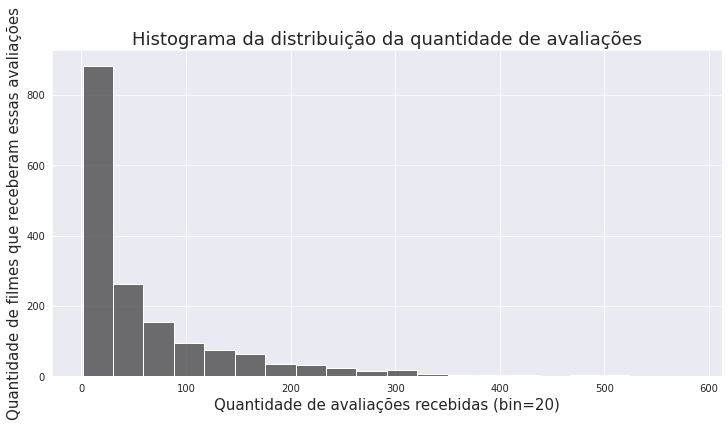

In [22]:
plt.figure(figsize=(12,6))
sns.histplot(df_agrupado['count'], bins=20, color='#404040')
plt.title('Histograma da distribuição da quantidade de avaliações', fontsize=18)
plt.xlabel('Quantidade de avaliações recebidas (bin=20)', fontsize=15)
plt.ylabel('Quantidade de filmes que receberam essas avaliações', fontsize=15)
plt.savefig("histograma_qtd_avaliacoes.png",dpi=400, bbox_inches='tight')
plt.show()

Este gráfico é interessante, mostra a distribuição da quantidade de avaliações recebidas pelos filmes. A leitura é simples, no eixo X temos a quantidade de avaliações recebidas pelo filme, separadas por grupos de 20. Já no eixo Y temos a quantidade de filmes que receberam essa quantidade de avaliações mencionada no eixo X. Em outras palavras, temos que mais de 800 filmes receberam até 20 avaliações. Isso demonstra a assimetria a direita na distribuição, ou seja, muitos filmes possuem poucas avaliações a poucos filmes recebem muitas avaliações.

#### Boxplot da quantidade de avaliações

Isso pode também ser confirmado pelo gráfico de boxplot, onde podemos notar que a linha preta no meio da pilha (mediana da quantidade de avaliações) está mais perto da primeira linha horizontal (1º quartil), e alguns outros outliers podem ser encontrados na parte superior (pontos pretos).

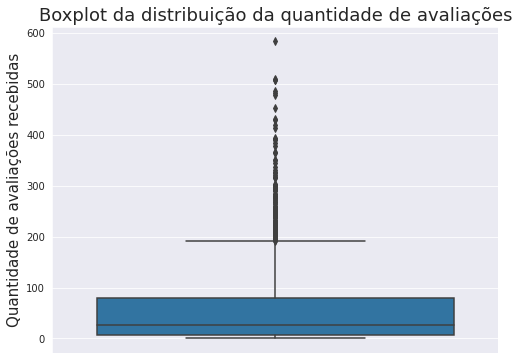

In [23]:
plt.figure(figsize=(8,6))
sns.boxplot(y = 'count', data = df_agrupado)
plt.title('Boxplot da distribuição da quantidade de avaliações', fontsize=18)
plt.ylabel('Quantidade de avaliações recebidas', fontsize=15)
plt.show()

#### Histrograma da média de avaliações

Da mesma maneira pode ser interessante analisar a média das avaliações dadas pelos usuários, então:

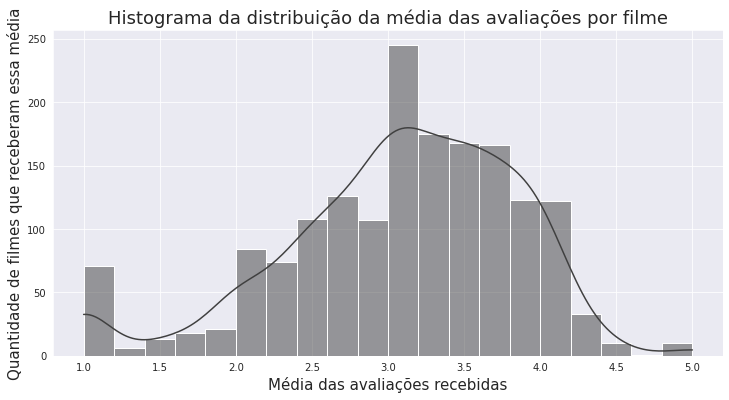

In [24]:
plt.figure(figsize=(12,6))
sns.histplot(df_agrupado['mean'], bins=20, kde=True, color='#404040')
plt.title('Histograma da distribuição da média das avaliações por filme', fontsize=18)
plt.ylabel('Quantidade de filmes que receberam essa média', fontsize=15)
plt.xlabel('Média das avaliações recebidas', fontsize=15)
plt.savefig("histograma_media_avaliacoes.png",dpi=400, bbox_inches='tight')
plt.show()

#### Boxplot da média de avaliações

Tanto com o histograma acima, como com o boxplot abaixo podemos notar uma concentração maior das médias de avaliações dos filmes entre 2,7 e 3,7. Mas a mediana por volta dos 3,2. Há ainda uma quantidade boa de filmes que tenham recebido nota média inferior a 2 e poucos que tenham recebido nota média por volta do 5.

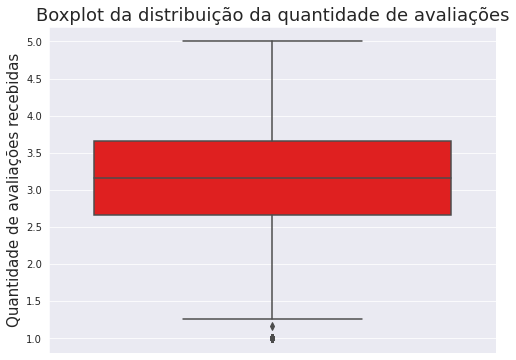

In [25]:
plt.figure(figsize=(8,6))
sns.boxplot(y = 'mean', data = df_agrupado, color='red')
plt.title('Boxplot da distribuição da quantidade de avaliações', fontsize=18)
plt.ylabel('Quantidade de avaliações recebidas', fontsize=15)
plt.show()

#### A relação entre média e quantidade de avaliações

Precisamente temos uma mediana geral de 27 avaliações por filme e uma nota médiana geral de 3,16.

In [26]:
df_agrupado.median()

id_filme    842.00000
count        27.00000
mean          3.16129
dtype: float64

Podemos explorar um pouco mais esses números abrindo pelo nome dos filmes em sí...

In [27]:
#Criando um dataframe temporário para a análise em questão
df_agrupado = df_agrupado.reset_index().merge(df_item, left_on='id_filme', right_on='id_filme', how='left')

Top 10 filmes que mais receberam avaliações:

In [28]:
df_agrupado[['nome_filme','count']].sort_values(by='count', ascending=False).head(10)

,nome_filme,count
1127,Star Wars (1977),583
859,Contact (1997),509
2,Fargo (1996),508
774,Return of the Jedi (1983),507
898,Liar Liar (1997),485
889,"English Patient, The (1996)",481
891,Scream (1996),478
0,Toy Story (1995),452
906,Air Force One (1997),431
235,Independence Day (ID4) (1996),429


Top 10 filmes mais bem avaliados (com pelo menos 50 avaliações cada):

In [29]:
df_agrupado[df_agrupado['count'] > 50][['nome_filme','mean', 'count']].sort_values(by='mean', ascending=False).head(10)

,nome_filme,mean,count
1025,"Close Shave, A (1995)",4.491071,112
925,Schindler's List (1993),4.466443,298
760,"Wrong Trousers, The (1993)",4.466102,118
1108,Casablanca (1942),4.456790,243
157,Wallace & Gromit: The Best of Aardman Animatio...,4.447761,67
1282,"Shawshank Redemption, The (1994)",4.445230,283
1242,Rear Window (1954),4.387560,209
223,"Usual Suspects, The (1995)",4.385768,267
1127,Star Wars (1977),4.358491,583
770,12 Angry Men (1957),4.344000,125


Será que podemos dizer que os filmes mais avaliados, o que é uma proxy para talvez os filmes mais vistos, também são os filmes melhor avaliados? De fato, apesar de existir alguma correlação entre essa quantidades, ela não é tão alta. Precisamente de 0,4. Então, nem sempre isso é verdade, apesar de existir uma certa tendência.

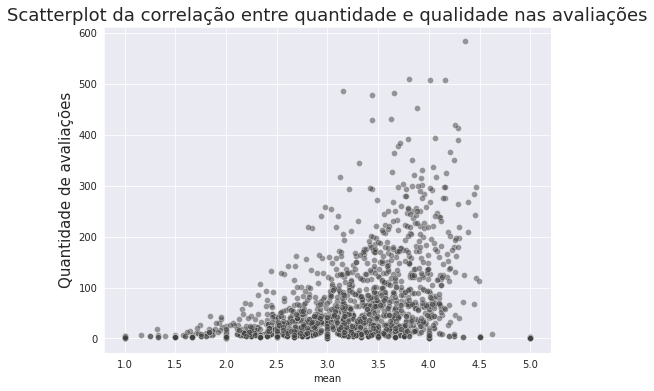

In [30]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='mean',y='count',data=df_agrupado,alpha=0.5, color='#404040')
plt.title('Scatterplot da correlação entre quantidade e qualidade nas avaliações', fontsize=18)
plt.ylabel('Média das avaliações', fontsize=15)
plt.ylabel('Quantidade de avaliações', fontsize=15)
plt.savefig("corr_qtd_media.png",dpi=400, bbox_inches='tight')
plt.show()

In [31]:
#Os números de correlação exatos vieram daqui:
df_agrupado[['mean','count']].corr()

,mean,count
mean,1.000000,0.429914
count,0.429914,1.000000


#### Quais são os temas que mais receberam avaliações

Lembrando que um filme pode pertencer a mais de um tema (irei contar então todas as vezes, para simplificar), temos a seguinte análise a ser feita:

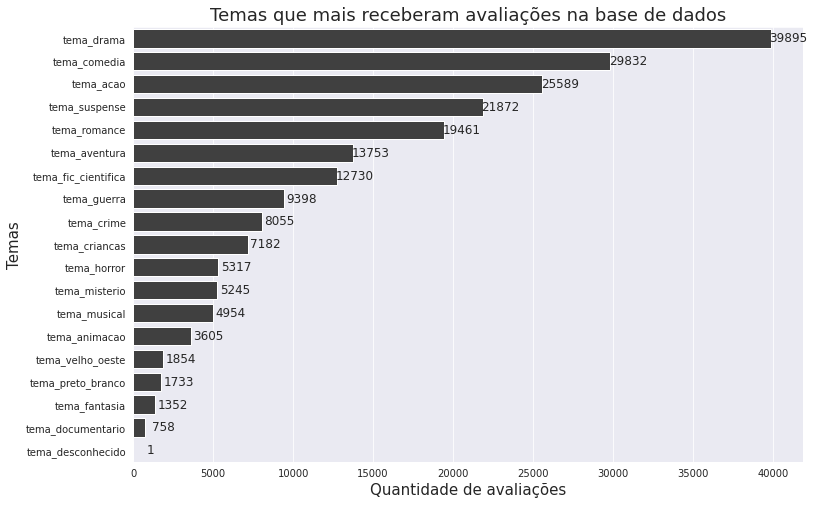

In [32]:
#Preparação do dado para a plotagem
cols = df_agrupado.columns[6:]
dict_cols = {coluna:0 for coluna in cols}

for i in df_agrupado.index:
    for coluna in cols:
        if (df_agrupado.iloc[i][coluna] == 1):
            dict_cols[coluna] += df_agrupado.iloc[i]['count']
dict_cols = {k: v for k, v in sorted(dict_cols.items(), key=lambda item: item[1], reverse=True)}

#plotagem
plt.figure(figsize=(12,8))
plt.title('Temas que mais receberam avaliações na base de dados', fontsize=18)
plt.ylabel('Temas', fontsize=15)
plt.xlabel('Quantidade de avaliações', fontsize=15)
sns.set(style="darkgrid")
ax = sns.barplot(x=list(dict_cols.values()), y=list(dict_cols.keys()), color='#404040')  #palette="Set2")

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_width() + 1100, (p.get_height()) +  p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.savefig("distribuicao_temas.png",dpi=400, bbox_inches='tight')

plt.show()

Temos que Drama foi o tema que mais recebeu avaliações, seguido por Comédia e Ação.

#### Quantidade de filmes publicados por ano

Analisando a quantidade de filmes publicados por ano podemos ver que alguns filmes bem antigos estão sendo avaliados mesmo depois de varios anos, mas o pico nos ultimos 5 anos ainda é o que mais representa a base de dados.

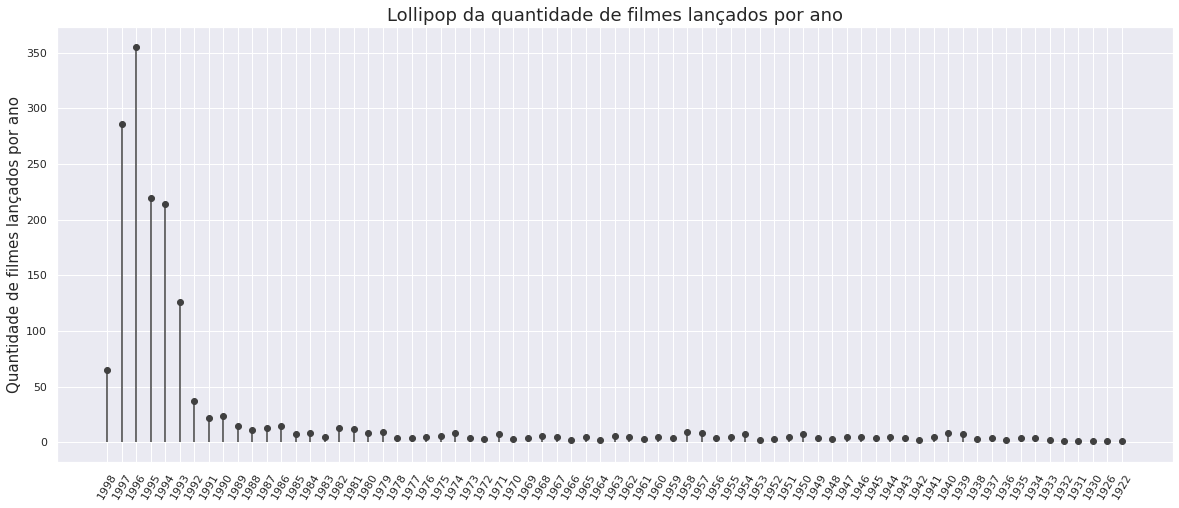

In [33]:
df_item['year'] = df_item['data_lancamento'].str[-4:]
g = df_item[['year','id_filme']].groupby(by='year').count().to_dict()
g = g['id_filme']
fig, ax = plt.subplots(figsize = (20, 8))

x=list(g.keys())[::-1]
y=list(g.values())[::-1]
ax.vlines(x, ymin=0, ymax=y, color='#404040')
ax.plot(x,y, "o", color='#404040')
ax.set_xticklabels(x, rotation = 60)
ax.set_ylabel("Quantidade de filmes lançados por ano", fontsize=15)
# set a title
ax.set_title("Lollipop da quantidade de filmes lançados por ano", fontsize=18)
plt.savefig("lollipop_qtd_ano.png",dpi=400, bbox_inches='tight')
plt.show()

#### Quantidade de avaliações por gênero

Analisando a quantidade de avaliações feitas por gênero temos que os homens tem maior presença na base de dados. Cerca de 2.9x mais avaliações.

In [34]:
df_usuarios.describe()

,idade
count,943.000000
mean,34.051962
std,12.192740
min,7.000000
25%,25.000000
50%,31.000000
75%,43.000000
max,73.000000


In [35]:
df = df.merge(df_usuarios, left_on='id_usuario', right_on='id_usuario', how='left')

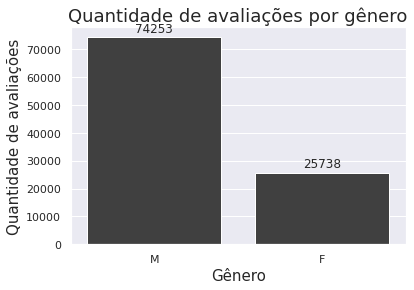

In [36]:
plt.figure()
ax = sns.countplot(x="sexo", data=df, color='#404040')#palette="Set2")
sns.set(style="darkgrid", rc={'figure.figsize':(12,8)})
plt.title('Quantidade de avaliações por gênero', fontsize=18)
plt.ylabel('Quantidade de avaliações', fontsize=15)
plt.xlabel('Gênero', fontsize=15)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.savefig("genero_avaliadores.png",dpi=400, bbox_inches='tight')
plt.show()

#### Quantidade de avaliações por estado (EUA)

Analisando a quantidade de avaliações feitas por cada estado dos EUA na base. Temos que Califórnia, Minnesota e Nova Iorque são os que tem maior presença na base de dados.

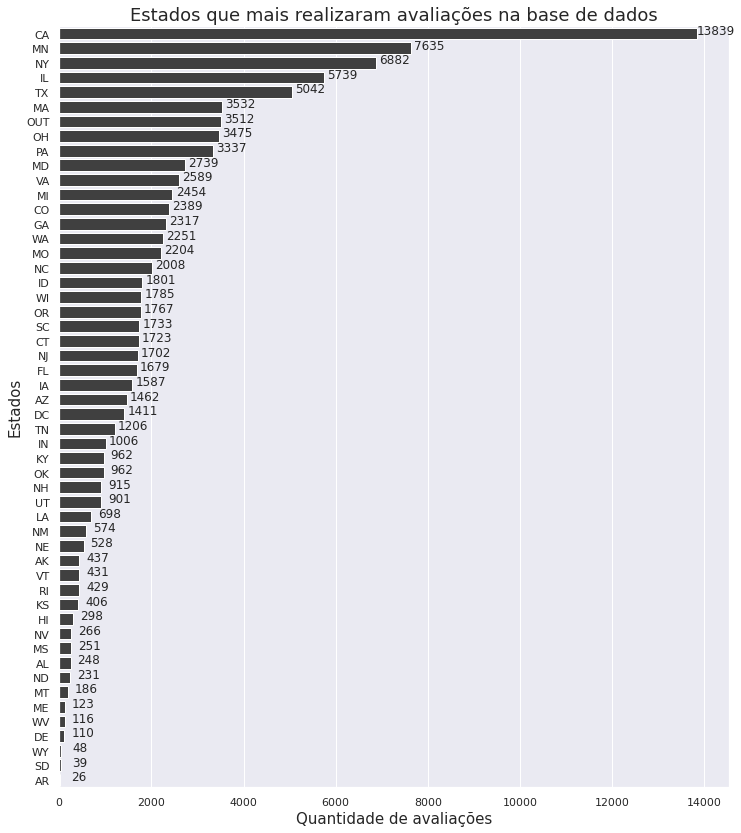

In [37]:
#Preparação do dado para a plotagem
dict_cols = df.groupby(by='estado_usa').count().to_dict()['id_usuario']
dict_cols = {k: v for k, v in sorted(dict_cols.items(), key=lambda item: item[1], reverse=True)}

#plotagem
plt.figure(figsize=(12,14))
plt.title('Estados que mais realizaram avaliações na base de dados', fontsize=18)
plt.ylabel('Estados', fontsize=15)
plt.xlabel('Quantidade de avaliações', fontsize=15)
sns.set(style="darkgrid")
ax = sns.barplot(x=list(dict_cols.values()), y=list(dict_cols.keys()), color='#404040')
    
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_width() + 400, (p.get_height()) +  p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("estado_avaliadores.png",dpi=400, bbox_inches='tight')    
plt.show()

#### Quantidade de avaliações por profissão

Analisando a quantidade de avaliações feitas por cada profissão na base. Temos que Estudantes são os que tem maior presença na base de dados. Cerca de 2x mais avaliações que a segunda categoria.

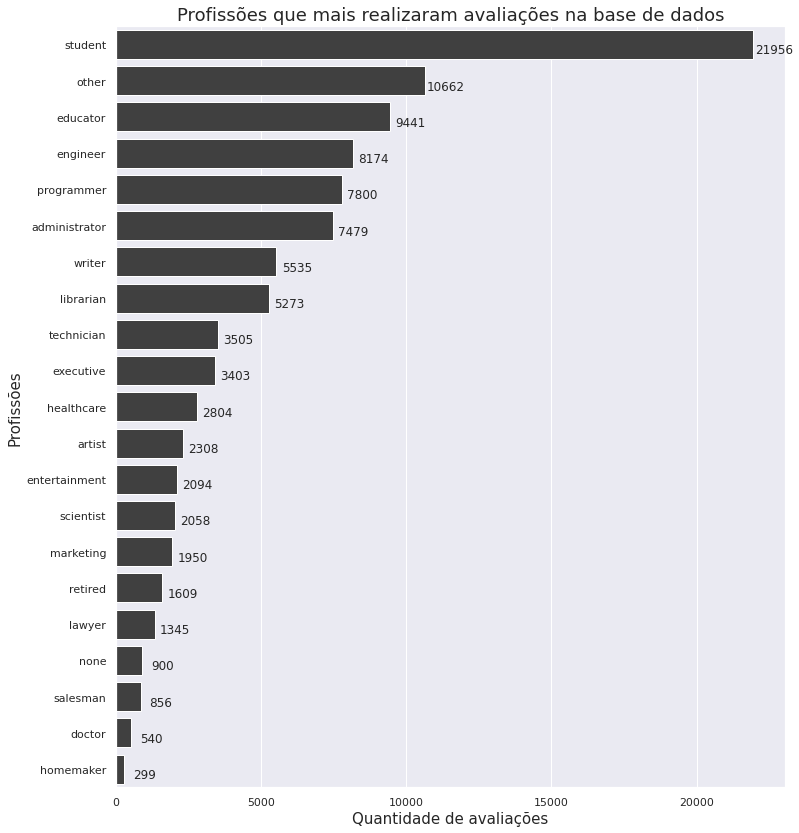

In [38]:
#Preparação do dado para a plotagem
dict_cols = df.groupby(by='profissao').count().to_dict()['id_usuario']
dict_cols = {k: v for k, v in sorted(dict_cols.items(), key=lambda item: item[1], reverse=True)}

#plotagem
plt.figure(figsize=(12,14))
plt.title('Profissões que mais realizaram avaliações na base de dados', fontsize=18)
plt.ylabel('Profissões', fontsize=15)
plt.xlabel('Quantidade de avaliações', fontsize=15)
sns.set(style="darkgrid")
ax = sns.barplot(x=list(dict_cols.values()), y=list(dict_cols.keys()),  color='#404040')
    
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_width() + 700, (p.get_height()) +  p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.savefig("profissao_avaliadores.png",dpi=400, bbox_inches='tight')       
plt.show()

## 4. Sistema de Recomendação

Criei a função abaixo para poder alternar entre uma abordagem que dividiria a base do estudo em treino e teste utilizando

- a biblioteca/metodo TRAIN TEST SPLIT padrão
- um metodo manual que preserva uma quantidade minima de 10 avaliações para cada filme no conjunto de teste

Isso se mostrou interessante posteriormente pois, ao aplicar os métodos de avaliação dos algoritmos de recomendação, era interessante garantir a existência de exemplos de 'sucesso', ou seja, de usuarios que tenham de fato assistido ao filme na base de dados para uma avaliação justa do desempenho.

In [39]:
if (1==1): ## Quando eu quisesse trocar para o corte padrão da base, faria essa condição dar errado
  df = df.sample(frac=1, random_state=42)
  df_aux = pd.DataFrame(columns=df.columns)
  df_test = pd.DataFrame(columns=df.columns)
  df_train = pd.DataFrame(columns=df.columns)

  df_contagem = pd.DataFrame(df.groupby(by=['id_usuario']).count()['id_filme']).reset_index()
  df_contagem.head()

  for i, rowi in df_contagem.iterrows():
    num_avals = rowi['id_filme']
    test_size = round(num_avals*0.3)

    if test_size >= 10:
      df_test = df_test.append(df[df['id_usuario']==rowi['id_usuario']].iloc[:test_size])
      df_train = df_train.append(df[df['id_usuario']==rowi['id_usuario']].iloc[test_size:])

  df_train['idade'] = df_train.idade.astype(int)
  df_train['avaliacao'] = df_train.avaliacao.astype(int)
else:
  df_train, df_test = train_test_split(df, test_size=0.30, random_state=42)

In [40]:
df_train.shape[0] + df_test.shape[0]

94593

### Popularidade

Como mencionado no início, a abordagem baseada em popularidade é a mais simples de todas. Olha diretamente para como este filme está se destacando dentre os outros dado critérios de quantidade e qualidade das avaliações recebidas, mas não distingue metadados de usuários e nem de filmes. É uma recomendação mais generalista. É o famoso "O que está bombando na Netflix".

O pipeline do nosso desenvolvimento seguirá os seguintes passos:

- Definir uma métrica de popularidade que relacione quantidade e qualidade das avaliações
- Aplicar esta métrica para os filmes da base
- Ordenar o resultado e apresentar o top-N

O primeiro ponto é muito importante para o prosseguimento, uma vez que podemos encontrar filmes muito bem avaliados que ainda não tenham uma quantidade rasoável de avaliações recebidas para ponderar a média. Poderíamos ter, por exemplo, um filme com 6 avaliações e uma média de 5, que não necessáriamente seria melhor que um outro filme que possuísse 90 avaliações e uma média de 4.7 . Neste caso, estaremos utilizando uma métrica desenvolvida pelo IMDb (Internet Movie Database) que visa balancear estes pesos.

Seja WR a média ponderada do IMDb, temos:

WR = ( R\*v + C*m ) / ( v+m )

onde,

- R --> média das avaliações recebidas por um filme
- v --> quantidade de avaliações recebidas por um filme
- C --> média de todas as avaliações da base de dados
- m --> é o mínimo de avaliações que um filme precisa para entrar no ranking

Para m, vou assumir que o 90º percentil é um bom número para ser utilizado como linha de corte. Ou seja, sempre que um filme estiver acima desse valor, ele receberá a métrica de popularidade e poderá ser retornado pela função.

Bora definir esta função então!

In [41]:
def wr_imdb(dataframe, nome_coluna_avaliacoes='avaliacao', nome_coluna_id_filme='id_filme', percentil_minimo_avaliacoes=0.9):
    """
    Função que executa a métrica de média ponderada definida pela IMDB
    
    
    Parâmetros
    ----------
    dataframe: DataFrame
        Pandas DataFrame que contem as informações necessárias para aplicação da função
    nome_coluna_avaliacoes: String
        O nome da coluna ao qual a formula será aplicada
    nome_coluna_id_filme: String
        O nome da coluna que identifica cada filme na base de dados
    percentil_minimo_avaliacoes: Float
        A quantidade do percentil que reflete o mínimo de avaliações necessárias para que um filme possa ser ranqueado
        
    
    Retorno
    ----------
    DataFrame
        Um Pandas DataFrame contendo em uma coluna o identificador de cada filme único na base e numa outra coluna a métrica de popularidade aplicada.
    """
    
    dataframe_auxiliar = dataframe[[nome_coluna_id_filme,nome_coluna_avaliacoes]].groupby(by=nome_coluna_id_filme).agg(['count','mean'])[nome_coluna_avaliacoes].reset_index()
    
    C = dataframe[nome_coluna_avaliacoes].mean()
    m = dataframe_auxiliar['count'].quantile(percentil_minimo_avaliacoes)
    
    lista_auxiliar = []
    for i in dataframe_auxiliar.index:
        if (dataframe_auxiliar.iloc[i]['count'] < m):
            lista_auxiliar.append(1)
        else:
            R = dataframe_auxiliar.iloc[i]['mean']
            v = dataframe_auxiliar.iloc[i]['count']
            lista_auxiliar.append( ( R*v + C*m ) / (v+m) )
    
    dataframe_auxiliar['popularidade'] = lista_auxiliar
    
    return dataframe_auxiliar[[nome_coluna_id_filme,'popularidade']].copy()

Vamos aplicar a função à nossa base de dados:

In [42]:
df_resultado_popularidade = wr_imdb(df_train)

Assim podemos ver os resultados obtidos para as 10 primeiras posições ordenadas pela popularidade.

In [43]:
df_resultado_popularidade.merge(df_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
1083,50,4.165130,Star Wars (1977)
881,318,4.143916,Schindler's List (1993)
1064,483,4.085769,Casablanca (1942)
1237,64,4.072046,"Shawshank Redemption, The (1994)"
221,12,4.065818,"Usual Suspects, The (1995)"
1611,98,4.063866,"Silence of the Lambs, The (1991)"
298,127,4.053984,"Godfather, The (1972)"
924,357,4.042669,One Flew Over the Cuckoo's Nest (1975)
722,174,4.024704,Raiders of the Lost Ark (1981)
1197,603,4.010858,Rear Window (1954)


### Popularidade nos últimos tempos

Também pode ser interessante análisar esta métrica de popularidade seguindo algum critério de período. Ou seja, pegar "o que está bombando nos ultimos tempos", e não na base de dados toda sem nenhum critério de busca. A netflix reconhecidamente faz este tipo de abordagem. Vamos ajustar a função definida acima acrescentando este parâmetro de período de tempo.

In [44]:
def current_wr_imdb(dataframe, nome_coluna_avaliacoes='avaliacao', nome_coluna_id_filme='id_filme', percentil_minimo_avaliacoes=0.9, periodo_maximo_considerado=30, nome_coluna_data_avaliacao='data_avaliacao'):
    """
    Função que executa a métrica de média ponderada definida pela IMDB, mas apenas para as avaliações feitas no período de tempo passado como parâmetro.
    
    
    Parâmetros
    ----------
    dataframe: DataFrame
        Pandas DataFrame que contem as informações necessárias para aplicação da função
    nome_coluna_avaliacoes: String
        O nome da coluna ao qual a formula será aplicada
    nome_coluna_id_filme: String
        O nome da coluna que identifica cada filme na base de dados
    percentil_minimo_avaliacoes: Float
        A quantidade do percentil que reflete o mínimo de avaliações necessárias para que um filme possa ser ranqueado
    periodo_maximo_considerado: Integer
        A quantidade de dias considerados na janela de análise
    nome_coluna_data_avaliacao: String
        O nome da coluna que contém a data da avaliação feita
        
    
    Retorno
    ----------
    DataFrame
        Um Pandas DataFrame contendo em uma coluna o identificador de cada filme único na base e numa outra coluna a métrica de popularidade aplicada.
    """
    
    dataframe_auxiliar = dataframe.copy()
    dataframe_auxiliar[nome_coluna_data_avaliacao] = pd.to_datetime(dataframe_auxiliar[nome_coluna_data_avaliacao])
    dataframe_auxiliar = dataframe_auxiliar[dataframe_auxiliar[nome_coluna_data_avaliacao] >=  dataframe_auxiliar[nome_coluna_data_avaliacao].max() - pd.Timedelta(days=periodo_maximo_considerado)].copy()
    
    return wr_imdb(dataframe_auxiliar, nome_coluna_avaliacoes, nome_coluna_id_filme, percentil_minimo_avaliacoes)

Vamos aplicar a função à nossa base de dados com um período de 30 dias:

In [45]:
df_resultado_popularidade_atual = current_wr_imdb(df_train)

Assim podemos ver os resultados obtidos para as 10 primeiras posições ordenadas pela popularidade atual.

In [46]:
df_resultado_popularidade_atual.merge(df_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
816,50,4.237789,Star Wars (1977)
625,318,4.201732,Schindler's List (1993)
665,357,4.194894,One Flew Over the Cuckoo's Nest (1975)
797,483,4.104818,Casablanca (1942)
1303,98,4.101543,"Silence of the Lambs, The (1991)"
928,603,4.099977,Rear Window (1954)
288,134,4.071402,Citizen Kane (1941)
737,427,4.068602,To Kill a Mockingbird (1962)
495,199,4.032581,"Bridge on the River Kwai, The (1957)"
575,272,4.024979,Good Will Hunting (1997)


Interessante notar que por exemplo "One Flew Over the Cuckoo's Nest (1975)", agora o terceiro, subiu algumas posições na tabela. Anteriormente esse filme ocupava a oitava posição. "Rear Window (1954)", por outro lado, subiu da décima para a sexta posição.

#### Busca por tema

Desenvolvemos também uma função que filtra a base de interações de acordo com um tema escolhido. Isso pode ser de ajuda em qualquer aplicação futura. Poderíamos por exemplo pegar os filmes com tema "crianças" mais populares, combinando as funções anteriormente construídas.

In [47]:
def search_theme(dataframe_interacoes, dataframe_filmes, theme):
    """
    Função que filtra o conjunto de dados principal (interações) de acordo com um tema passado como parâmetro.
    
    
    Parâmetros
    ----------
    dataframe_interacoes: DataFrame
        Pandas DataFrame que contem as informações das avaliações realizadas ao longo do tempo
    dataframe_filmes: DataFrame
        Pandas DataFrame que contem as informações dos temas de cada filme
    theme: String
        Nome da coluna que indica o tema a ser procurado.
        
        
    Retorno
    ----------
    DataFrame
        Existem dois retornos possíveis:
            1. Um Pandas DataFrame vazio, caso a string passada como parâmetro em "theme" não encontre nenhuma coluna no dataframe de filmes; e caso contrário
            2. Um Pandas DataFrame contendo o dataframe de interações (avaliações) filtrado pelo tema passado como parâmetro.
    
    """
    
    if (theme not in dataframe_filmes.columns):
        print( "Erro: O tema que você está procurando não foi encontrado" )
        return pd.DataFrame()
    else:
        
        
        dataframe_filmes['filtro'] = True
        dataframe_interacoes = dataframe_interacoes.merge(dataframe_filmes[dataframe_filmes[theme]==1][['id_filme','filtro']], left_on='id_filme', right_on='id_filme', how='left')
        
        return dataframe_interacoes[dataframe_interacoes['filtro'].notna()].copy()
        

Os filmes com o tema "crianças" mais populares dos últimos 30 dias:

In [48]:
current_wr_imdb(search_theme(df_train, df_item, "tema_criancas")).merge(df_item[['id_filme','nome_filme']],
                                                                  left_on='id_filme', right_on='id_filme', 
                                                                  how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
21,132,4.001534,"Wizard of Oz, The (1939)"
87,8,3.859608,Babe (1995)
72,588,3.835912,Beauty and the Beast (1991)
106,99,3.788518,Snow White and the Seven Dwarfs (1937)
59,432,3.759113,Fantasia (1940)
0,1,3.752233,Toy Story (1995)
57,423,3.728037,E.T. the Extra-Terrestrial (1982)
41,304,3.644782,Fly Away Home (1996)
102,95,3.583128,Aladdin (1992)
81,71,3.576008,"Lion King, The (1994)"


### Recomendação baseada em informações demográficas

A ideia seria construirmos uma abordagem um pouco mais persnalizada que a baseada apenas em Popularidade, e que possa nos ajudar com os problemas de novos usuários (user-cold-start) que ainda não tem um histórico de preferências. Como temos alguns dados demográficos sobre os usuários como a Idade, Sexo, Profissão e até o estado cadastrado em sistema, podemos criar grupos de interessse e assumir que os filmes vistos por esse grupo podem ser de interesse para qualquer pertencente dele.

O pipeline do nosso desenvolvimento seguirá os seguintes passos:

- Utilizar as informações demográficas pertencentes ao dataset de usuários (Idade, Sexo, Profissão e UF)
- Encontrar grupos de pertencimento a cada usuário, onde os usuários de um mesmo grupo tenham perfis demográficos parecidos (Hierarchical Clustering)
- Para um dado grupo, encontrar a lista de todos os filmes que pelo menos um usuário pertencente a esse grupo tenha assistido
- Aplicar a métrica de Popularidade definida acima para ordenar essa lista de filmes e sugerir os primeiros para o usuário

In [49]:
df_usuarios.head()

,id_usuario,idade,sexo,profissao,estado_usa
0,1,24,M,technician,AZ
1,2,53,F,other,CA
2,3,23,M,writer,FL
3,4,24,M,technician,OH
4,5,33,F,other,PA


Precisamos preparar o dataset para aplicarmos a clusterização. Vou optar por não normalizar o conjunto de dados.

In [50]:
df_clustering = pd.get_dummies(df_usuarios[['idade','sexo','profissao','estado_usa']])
df_clustering.head()

,idade,sexo_F,sexo_M,profissao_administrator,profissao_artist,profissao_doctor,profissao_educator,profissao_engineer,profissao_entertainment,profissao_executive,...,estado_usa_SD,estado_usa_TN,estado_usa_TX,estado_usa_UT,estado_usa_VA,estado_usa_VT,estado_usa_WA,estado_usa_WI,estado_usa_WV,estado_usa_WY
0,24,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,53,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,23,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Clusterização hierárquica

Realizamos alguns testes também com os algorítmos DBSCAN e K-Médias, mas aparentemente a clusterização hierárquica (em específico utilizando a métrica euclidiana de distância e o método de ward) foi a que apresentou os melhores resultados, e ainda por cima possibilita essa visualização da árvore gerada.

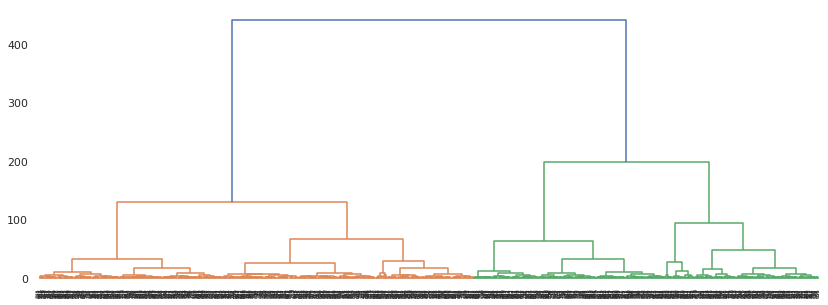

In [51]:
#Para o ward temos
plt.figure(figsize=(14,5))
mergings = linkage(df_clustering, method="ward", metric='euclidean')
dendrogram(mergings)
plt.savefig("dendograma_.png",dpi=400, bbox_inches='tight')   
plt.show(True)


Fizemos alguns testes baseando-se na métrica do Silhuete Score para encontrarmos o ponto ótimo de corte para a arvore.

In [52]:
for i in range(2,20):
    df_clustering['ClusterHWard'] = cut_tree(mergings, n_clusters=i).reshape(-1, )
    print(i," - Ward's Silhouette score:", silhouette_score(df_clustering, df_clustering['ClusterHWard'], metric='euclidean'))

2  - Ward's Silhouette score: 0.5813595651258254
3  - Ward's Silhouette score: 0.5178327240229024
4  - Ward's Silhouette score: 0.46018936051137177
5  - Ward's Silhouette score: 0.4592891000984346
6  - Ward's Silhouette score: 0.45902059659391464
7  - Ward's Silhouette score: 0.4507638544377831
8  - Ward's Silhouette score: 0.4729673997902301
9  - Ward's Silhouette score: 0.49650671995252166
10  - Ward's Silhouette score: 0.5184138121388
11  - Ward's Silhouette score: 0.5043316028996516
12  - Ward's Silhouette score: 0.5031424447977649
13  - Ward's Silhouette score: 0.47545555469672046
14  - Ward's Silhouette score: 0.4465830459954663
15  - Ward's Silhouette score: 0.4308141507251539
16  - Ward's Silhouette score: 0.44563792637164695
17  - Ward's Silhouette score: 0.45584051405445225
18  - Ward's Silhouette score: 0.4509701866932091
19  - Ward's Silhouette score: 0.4556164547784083


Mesmo sem normalizar o conjunto de dados, obtivemos bons resultados das métricas de Silhouette score. O número ideal de cluster parece ser 10, ponto em que maximizamos a métrica quando olhamos para um maior número de clusters. Ajustaremos então o conjunto de dados inicial com os grupos, e depois faremos a recomendação um pouco mais personalizada.

In [53]:
df_usuarios['grupo'] = cut_tree(mergings, n_clusters=10).reshape(-1, )

In [54]:
df_usuarios.head()

,id_usuario,idade,sexo,profissao,estado_usa,grupo
0,1,24,M,technician,AZ,0
1,2,53,F,other,CA,1
2,3,23,M,writer,FL,0
3,4,24,M,technician,OH,0
4,5,33,F,other,PA,2


#### Função de recomendação

Agora desenvolveremos a função que filtrará o conjunto de dados de interação com base no cluster ao qual um dado usuário pertença. Assim, poderemos aplicar as funções acima desenvolvidas para pegar os filmes mais populares que podem ser de interesse a qualquer usuário do grupo.

In [55]:
def get_recommendations_clusterized(iid_usuario, dataframe_usuarios, dataframe, nome_coluna_id_usuario='id_usuario', nome_coluna_id_filme='id_filme', nome_coluna_grupo='grupo'):
    """
    Função que executa a métrica de média ponderada definida pela IMDB, mas apenas para as avaliações feitas no período de tempo passado como parâmetro.
    
    
    Parâmetros
    ----------
    iid_usuario: String
        O id de identificação do usuário ao qual queremos encontrar o grupo
    dataframe_usuarios: DataFrame
        Pandas DataFrame que contem as informações necessárias dos usuários
    dataframe: DataFrame
        Pandas DataFrame que contem as informações necessárias para aplicação da função
    nome_coluna_id_usuario: String
        O nome da coluna que identifica cada usuario na base de dados
    nome_coluna_id_filme: String
        O nome da coluna que identifica cada filme na base de dados
    nome_coluna_grupo: String
        O nome da coluna que identifica cada grupo na base de dados
        
    
    Retorno
    ----------
    DataFrame
        Um Pandas DataFrame que é uma cópia do dataframe das interações, mas agora filtrado pelas interações dos usuários do grupo do usuário passado como parâmetro.
    """
    
    dataframe_auxiliar = dataframe.copy()
    dataframe_auxiliar_usuarios = dataframe_usuarios.copy()
    
    grp = list(dataframe_auxiliar_usuarios[dataframe_auxiliar_usuarios[nome_coluna_id_usuario]==str(iid_usuario)][nome_coluna_grupo])[0]
    dataframe_auxiliar = dataframe_auxiliar.merge(dataframe_auxiliar_usuarios[dataframe_auxiliar_usuarios[nome_coluna_grupo]==grp][[nome_coluna_id_usuario,nome_coluna_grupo]], left_on=nome_coluna_id_usuario, right_on=nome_coluna_id_usuario, how='left')
    dataframe_auxiliar = dataframe_auxiliar[dataframe_auxiliar[nome_coluna_grupo].notna()]
    #[inicio] retirar filmes ja assistido pelo usuario
    dataframe_auxiliar_ = dataframe_auxiliar[[nome_coluna_id_usuario,nome_coluna_id_filme]].copy()
    dataframe_auxiliar_.columns = ['iid_usuario','iid_filme']
    dataframe_auxiliar_ = dataframe_auxiliar_[dataframe_auxiliar_['iid_usuario']==str(iid_usuario)]
    dataframe_auxiliar = dataframe_auxiliar.merge(dataframe_auxiliar_, how='left', left_on=nome_coluna_id_filme, right_on='iid_filme')
    dataframe_auxiliar = dataframe_auxiliar[dataframe_auxiliar['iid_filme'].isna()]
    #[fim] retirar filmes ja assistido pelo usuario
    dataframe_auxiliar.drop(columns=['iid_filme','iid_usuario'], inplace=True)

    return dataframe_auxiliar

Vamos aplicar a função à nossa base de dados com um período de 30 dias:

In [56]:
df_resultado_popularidade_atual = current_wr_imdb(get_recommendations_clusterized('3', df_usuarios, df_train))

Assim podemos ver os resultados obtidos para o grupo do usuário 3 (ele pertence ao grupo 0) das 10 primeiras posições ordenadas pela popularidade atual.

In [57]:
df_resultado_popularidade_atual.merge(df_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
46,11,4.220472,Seven (Se7en) (1995)
404,56,4.135675,Pulp Fiction (1994)
69,12,4.095472,"Usual Suspects, The (1995)"
632,98,4.076378,"Silence of the Lambs, The (1991)"
482,7,4.063648,Twelve Monkeys (1995)
225,258,4.054556,Contact (1997)
369,50,3.986105,Star Wars (1977)
264,313,3.983127,Titanic (1997)
191,22,3.980315,Braveheart (1995)
119,151,3.976378,Willy Wonka and the Chocolate Factory (1971)


Note que se escolhessemos um usuário que pertença a outro grupo, como no caso a usuária 2 (que pertence ao grupo 1), as recomendações atuais mais populares seriam outras.

In [58]:
df_resultado_popularidade_atual = current_wr_imdb(get_recommendations_clusterized('2', df_usuarios, df_train))
df_resultado_popularidade_atual.merge(df_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
209,357,4.500507,One Flew Over the Cuckoo's Nest (1975)
322,528,4.417427,"Killing Fields, The (1984)"
427,651,4.417427,Glory (1989)
527,9,4.417427,Dead Man Walking (1995)
28,12,4.417427,"Usual Suspects, The (1995)"
112,199,4.357794,"Bridge on the River Kwai, The (1957)"
540,98,4.357794,"Silence of the Lambs, The (1991)"
132,22,4.357794,Braveheart (1995)
104,191,4.357794,Amadeus (1984)
94,181,4.313070,Return of the Jedi (1983)


Se por exemplo pegássemos outro usuário do grupo inicial (grupo 0), como o usuário 4 abaixo, as recomendações são praticamente as mesmas que as feitas ao usuário 3. Isso acontece porque as informações demográficas de ambos indicam que eles pertencem ao mesmo grupo, mas levamos também em consideração também apenas recomendar filmes inéditos a cada usuário. Então a lista se distingue por conta disso.

In [59]:
df_resultado_popularidade_atual = current_wr_imdb(get_recommendations_clusterized('4', df_usuarios, df_train))
df_resultado_popularidade_atual.merge(df_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
46,11,4.222667,Seven (Se7en) (1995)
437,56,4.137026,Pulp Fiction (1994)
69,12,4.097667,"Usual Suspects, The (1995)"
238,272,4.086815,Good Will Hunting (1997)
665,98,4.078133,"Silence of the Lambs, The (1991)"
515,7,4.065111,Twelve Monkeys (1995)
225,258,4.055810,Contact (1997)
402,50,3.987137,Star Wars (1977)
273,313,3.984381,Titanic (1997)
191,22,3.981778,Braveheart (1995)


Esse tipo de abordagem de recomendação é bem positiva se você considerar os usuários que ainda não têm um histórico de filmes assistidos, pois eles conseguiriam receber recomendações um pouco mais personalizadas mesmo com esse contraponto. Por outro lado, uma abordagem colaborativa é mais indicada se você realmente quiser utilizar as preferencias individuais de cada usuário. Definiremos essa abordagem nos próximos tópicos.

### Baseados em Filtragem-Colaborativa

A abordagem anterior, apesar de dar início minimamente a personalização de recomendações, sofre por não considerar os viéses e preferências individuais de cada usuário. Como dissemos no início, algorítmos baseados em filtragem colaborativa assumem o histórico cruzado entre usuários e filmes. Existem dois tipos em específico,

- Filtragem Colaborativa Baseada em Usuários

Assume que um usuário deve gostar de itens bem avaliados por usuários com gostos parecidos aos dele. Para medir a semelhança entre dois usuários, podemos usar a correlação de Pearson ou a semelhança de cosseno.

Embora computar a Filtragem Colaborativa Baseada em Usuários seja muito simples, ela apresenta vários problemas. Um dos principais problemas é que as preferências dos usuários podem mudar com o tempo. Isso indica que o pré-cálculo da matriz com base nos usuários vizinhos pode levar a um desempenho ruim. Para resolver esse problema, podemos aplicar a Filtragem Colaborativa Baseada em Item.

- Filtragem Colaborativa Baseada em Item

Aqui, em vez de medir a semelhança entre os usuários, ela recomenda itens com base nas semelhanças dos itens que o usuário-alvo classificou. Da mesma forma, a similaridade pode ser calculada com correlação de Pearson ou similaridade de cosseno.

Ele evita o problema da preferência dinâmica do usuário, pois torna a similaridade mais específica baseando-se no item. No entanto, vários problemas permanecem para este método como um todo. O principal problema é a escalabilidade, pois o cálculo cresce tanto com o aumento do número de clientes quanto com o de filmes. O pior caso de complexidade é O (mn) com m usuários e n filmes. Além disso, a dispersão é outra preocupação. Em casos extremos, podemos ter milhões de usuários e filmes e a semelhança entre dois filmes bastante diferentes pode ser muito alta simplesmente porque eles têm uma única classificação semelhante para o único usuário que classificou os dois.

#### Single Value Decomposition

Uma maneira de lidar com o problema de escalabilidade e esparsidade criado pela Filtragem Colaborativa é utilizar um modelo de Fator Latente para capturar a similaridade entre usuários e itens. O nome é bonito, parece complexo, mas a implementação é simples e, essencialmente, queremos transformar o problema de recomendação em um problema de otimização. O lado positivo de se trabalhar com modelos desse tipo é que podemos avaliar quão boa é a capacidade de prever filmes a um usuário. Uma métrica comum é o erro quadrático médio (RMSE). Quanto menor o RMSE, melhor será o desempenho do modelo.

Agora, falando sobre o Fator Latente em sí: É uma ideia ampla que descreve uma propriedade ou conceito de redução de dimensionalidade em dados. Por exemplo, para explicar uma música, um Fator Latente pode se referir ao gênero ao qual a música pertence. Seria como encontrar uma característica principal, ou várias delas. Descobrir uma direção não óbvia (e de forma otimizada) que possa explicar a relação entre essas características dado uma grande quantidade de filmes assistidos por diversos usuários é o objetivo desse conceito na nossa aplicação.

Parte conceitual e teórica OK, vamos de código!

Para a implementação, precisamos passar pelas métricas de ajuste que serão utilizadas (RSME e MAE) e também especificar quantas seções existem no dataset, no nosso caso divisões se baseiam nas notas que variam de 1 a 5.

In [60]:
reader = Reader(rating_scale=(1, 5))
svd = SVD()

Para o objeto (matriz com propriedades otimizadas) precisaremos dos ids de usuário e dos filme e da avaliação dada por cada um deles.

In [61]:
data = Dataset.load_from_df(df_train[['id_usuario', 'id_filme', 'avaliacao']], reader)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9485  0.9529  0.9544  0.9520  0.0025  
MAE (testset)     0.7513  0.7513  0.7545  0.7524  0.0015  
Fit time          4.89    4.89    4.88    4.89    0.01    
Test time         0.23    0.45    0.22    0.30    0.10    


{'test_rmse': array([0.94852433, 0.95294545, 0.95440556]),
 'test_mae': array([0.75134718, 0.75130365, 0.75453742]),
 'fit_time': (4.893605470657349, 4.8934712409973145, 4.8814568519592285),
 'test_time': (0.2276933193206787, 0.44713425636291504, 0.22362613677978516)}

O resultado da avaliação do modelo indica que as previsões feitas poderão ter erros que variam em média 0,75 para mais ou para menos. O que é relativamente bom/aceitável.

In [62]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Treinamento realizado, vamos testar um caso que anteriormente tínhamos testado com a abordagem de Popularidade Demográfica. Abaixo uma amostra de alguns filmes que o usuário '2' já assitiu, bem como sua avaliação para eles.

In [63]:
df_train[df_train['id_usuario'] == '2'][['id_usuario','id_filme','avaliacao']].head(3)

,id_usuario,id_filme,avaliacao
97611,2,296,3
42953,2,311,5
55783,2,100,5


Para esse conjunto que já conhecemos, podemos verificar as previsões do modelo. Para o filme 296, em que o usuário inicialmente avaliou com a nota 3, teria como resultado no modelo a previsão de 3.41, conforme mostrado abaixo:

In [64]:
svd.predict('2', '296').est

3.3202472964545526

O que contém um erro absoluto de 0.41. Um outro exemplo seria para o filme 100, o qual o usuário inicialmente avaliou como 5, recebemos pela avaliação do modelo a nota 4.37. O que tem um erro absoluto de 0.63. Em média, teríamos como mencionado anteriormente 0.75 de erro absoluto medio para toda a amostra.

In [65]:
svd.predict('2', '100').est

4.439393396495534

Agora para casos ainda não vistos para o usuário, temos uma constatação interessante. Relembrando, pela abordagem de Popularidade Demográfica as três primeiras recomendações de filmes para o usuário '2' seriam as ilustradas abaixo:

In [66]:
df_resultado_popularidade_atual = current_wr_imdb(get_recommendations_clusterized('2', df_usuarios, df_train))
df_resultado_popularidade_atual.merge(df_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(3)

,id_filme,popularidade,nome_filme
209,357,4.500507,One Flew Over the Cuckoo's Nest (1975)
322,528,4.417427,"Killing Fields, The (1984)"
427,651,4.417427,Glory (1989)


São os filmes mais populares de acordo com o grupo em que ele pertence. Mas com a abordagem de Filtragem Colaborativa, que é mais personalizada, teríamos que o segundo filme tem uma maior similaridade com o usuário do que o filme primeiro filme. Conforme mostrado abaixo, para o filme 357, a nota prevista para o usuário '2' seria 4.34.

In [67]:
svd.predict('2', '357').est

4.375681107715587

Enquanto que para o filme 528, a nota prevista para o usuário '2' seria 4.39!

In [68]:
svd.predict('2', '528').est

4.219085908788195

Por fim, definiremos então uma função para varrer todos os filmes para um determinado usuário e assim encontrar as melhores recomendações para ele, segue:

In [69]:
def get_recommendations_collaborative_filtering(iid_usuario, dataframe_svd, dataframe_filmes, dataframe, n=5, nome_coluna_id_filme='id_filme', nome_coluna_id_usuario = 'id_usuario'):
    """
    Função que procura as melhores recomendações de filmes para um dado usuário
    
    
    Parâmetros
    ----------
    iid_usuario: String
        O id de identificação do usuário ao qual queremos sugerir recomendações
    dataframe_svd: DataFrame
        Objeto SVD que contem o dados treinados para o modelo
    dataframe_filmes: DataFrame
        Pandas DataFrame que contem as informações necessárias para identificação dos filmes
    dataframe: DataFrame
        Pandas DataFrame que contem as informações das interações entre filmes e usuarios
    nome_coluna_id_filme: String
        O nome da coluna que identifica cada filme na base de dados
    n: Integer
        Número inteiro que representa a quantidade de filmes que será retornada
        
    
    Retorno
    ----------
    DataFrame
        Um Pandas DataFrame que contém o top N filmes mais prováveis para o usuário
    """
    
    films_list = list(dataframe_filmes[nome_coluna_id_filme].unique())
    score_list = []
    
    for f in films_list:
        score_list.append(dataframe_svd.predict(str(iid_usuario), str(f)).est)
        
    dataframe_output = pd.DataFrame([str(iid_usuario)]*len(films_list), columns=[nome_coluna_id_usuario])
    dataframe_output[nome_coluna_id_filme] = films_list
    dataframe_output['avaliacao'] = score_list
    dataframe_output = dataframe_output.sort_values(by='avaliacao',ascending=False)
    df_aux = dataframe[dataframe[nome_coluna_id_usuario]==iid_usuario][[nome_coluna_id_filme, 'data_avaliacao']]
    dataframe_output = dataframe_output.merge(df_aux, how='left', left_on=nome_coluna_id_filme, right_on=nome_coluna_id_filme)
    dataframe_output = dataframe_output[dataframe_output['data_avaliacao'].isna()]
    dataframe_output.drop(columns=['data_avaliacao'],inplace=True)

    return dataframe_output.head(n)

In [70]:
df_resultado_filtragem_colaborativa = get_recommendations_collaborative_filtering('2',svd,df_item, df_train, 10)
df_resultado_filtragem_colaborativa.merge(df_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left')

,id_usuario,id_filme,avaliacao,nome_filme
0,2,169,4.742948,"Wrong Trousers, The (1993)"
1,2,12,4.724669,"Usual Suspects, The (1995)"
2,2,408,4.722708,"Close Shave, A (1995)"
3,2,318,4.722634,Schindler's List (1993)
4,2,515,4.640578,"Boot, Das (1981)"
5,2,513,4.606041,"Third Man, The (1949)"
6,2,64,4.580015,"Shawshank Redemption, The (1994)"
7,2,114,4.562734,Wallace & Gromit: The Best of Aardman Animatio...
8,2,302,4.523781,L.A. Confidential (1997)
9,2,480,4.489408,North by Northwest (1959)


As 10 melhores recomendações para o usuário '2' são as descritas acima.

### Baseados em Filtragem-Colaborativa por Redes Complexas (Adamic Adar Link Prediction)

A ideia desta abordagem seria utilizar métodos da Teoria das Redes Complexas para encontrar a similiridade entre os filmes assistidos pelos usuários. As funções abaixo auxiliam na criação de um Grafo onde cada filme esta conectado com outro filme se um usuário assistiu a ambos os filmes. Para cada usuário criaremos essa relação e então com isso teremos uma rede interconectada.

In [71]:
def get_genres(iid_filme, dataframe_filme, columns, nome_coluna_id_filme='id_filme'):
  """
    Função que organiza o uma lista de temas que um filme pode ter
    
    
    Parâmetros
    ----------
    iid_filme: String
        O id de identificação do filme ao qual queremos procurar os temas
    dataframe_filme: DataFrame
        O dataframe que contem o dados dos filmes
    columns: List
        Lista que contém todas as colunas para cada tema possível que um filme pode ter
    nome_coluna_id_filme: String
        String que armazena o nome da coluna que identifica os filmes no dataframe de filmes   
    
    Retorno
    ----------
    List
        Uma lista de temas que o filme passado como parâmetro é classificado
    """
  genres_list = list()
  dataframe_line = dataframe_filme[dataframe_filme[nome_coluna_id_filme] == iid_filme]
  for col in columns:
    if dataframe_line[col].values[0] == 1:
      genres_list.append(col)
  return genres_list

Além dessas conexões diretas pelos filmes assistidos, criamos também conexões secundárias que se baseiam em características dos filmes e dos usuários. Um exemplo dessas subconexões se da pelo Tema de cada Filme. Sempre que há uma correspondência entre dois filmes com relação ao seu tema, criamos a conexão entre os nós na rede. A mesma ideia foi utilizada para o ano de lançamento dos filmes e também para o GRUPO pertencente a cada usuário que assistiu. Os grupos foram definidos nas seções anteriores, onde utilizamos a clusterização da base de usuários por meio das suas características demográficas.

In [72]:
def generate_graph(dataframe, dataframe_filmes, dataframe_usuarios, nome_coluna_id_filme='id_filme', nome_coluna_id_usuaio='id_usuario', nome_coluna_grupo='grupo', nome_coluna_ano='year'):
  """
    Função que gera o Grafo a partir das regras de negócio definidas nesta aplicação.
    Isto é, relaciona usuarios que assistiram aos filmes com os temas dos filmes e 
    o ano de lançamento dos filmes, bem como com a caracteristica de qual grupo o 
    usuário que assistiu pertence.
    
    
    Parâmetros
    ----------
    dataframe: DataFrame
        O dataframe que contem o dados de interação entre usuários e filmes assistidos
    dataframe_filmes: DataFrame
        O dataframe que contem o dados dos filmes
    dataframe_usuarios: DataFrame
        O dataframe que contem o dados dos usuários que assistem os filmes
    nome_coluna_id_filme: String
        String que armazena o nome da coluna que identifica os filmes nos dataframes
    nome_coluna_id_usuaio: String
        String que armazena o nome da coluna que identifica os usuários nos dataframes
    nome_coluna_grupo: String
        String que armazena o nome da coluna que identifica os grupos aos quais os usuarios pertencem nos dataframes
    nome_coluna_ano: String
        String que armazena o nome da coluna que identifica os anos de lançamento dos filmes nos dataframes
    
    Retorno
    ----------
    Graph
        Um grafo criado a partir dos dataframes passados como parâmetros
    """
  
  G_ = nx.Graph(label="MOVIE")
  for i, rowi in dataframe.iterrows():
    G_.add_node(rowi[nome_coluna_id_filme],label="FILME")
    G_.add_node("user_"+rowi[nome_coluna_id_usuaio],label="USUARIO")
    G_.add_edge(rowi[nome_coluna_id_filme], "user_"+rowi[nome_coluna_id_usuaio], label="ASSISTIU")

  df_aux = dataframe.merge(dataframe_usuarios[[nome_coluna_id_usuaio,'grupo']], how='left', left_on=nome_coluna_id_usuaio, right_on=nome_coluna_id_usuaio)[[nome_coluna_id_filme,nome_coluna_grupo]].drop_duplicates()
  dicio_cluster = dict()
  for i, rowi in df_aux.iterrows():
    G_.add_node("group_"+str(rowi[nome_coluna_grupo]),label="GRUPO")
    G_.add_edge(rowi[nome_coluna_id_filme], "group_"+str(rowi[nome_coluna_grupo]), label="GRUPO")

  for i, rowi in dataframe_filmes.iterrows():
    if rowi[nome_coluna_id_filme] in G_.nodes:
      for subject in get_genres(rowi[nome_coluna_id_filme],dataframe_filmes, nome_dos_temas):
        G_.add_node(subject,label="TEMA")
        G_.add_edge(rowi[nome_coluna_id_filme], subject, label="TEMA")

        ano = rowi[nome_coluna_ano]
        G_.add_node("year_"+str(ano),label="ANO")
        G_.add_edge(rowi[nome_coluna_id_filme], "year_"+str(ano), label="ANO")

  return G_

A função abaixo foi definida para obter recomendações dos filmes para um dado grafo que contém os históricos de preferências dos usuários.

In [73]:
def get_recommendation_from_graph(G_, root):
    """
    Função que retorna recomendações de filmes para um dado usuario passado como parâmetro
    
    
    Parâmetros
    ----------
    G_: Graph
        O grafo que armazena as relações existentes entre os dataframes de filmes e usuários
    root: String
        O nó do grafo que representa o usuário ao qual queremos gerar recomendações

    Retorno
    ----------
    DataFrame
        Um DataFrame que contem as recomendações de filmes para o usuário passado como parâmetro
    """

    commons_dict = {}
    for e in G_.neighbors(root):
        for e2 in G_.neighbors(e):
            if e2==root:
                continue
            if G_.nodes[e2]['label']=="FILME":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G_.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result

Demonstração dos resultados que podem ser obtidos com a função para o filme 999.

In [74]:
G = generate_graph(df_train, df_item, df_usuarios)

In [75]:
get_recommendation_from_graph(G, "999").head()

70     1.534068
202    1.527180
173    1.527180
1      1.367081
732    1.367081
dtype: float64

Geramos uma exemplificação gráfica da relação entre dois filmes, o 999 e o 1499. Para isso algumas funções precisaram ser definidas, a explicação detalhada delas foge ao escopo dessa apresentação.

In [76]:
def get_all_adj_nodes(G_, list_in):
    """
    Função para pegar os vizinhos diretos de cada filme passado como parâmetro
    
    Parâmetros
    ----------
    G_: Graph
        O grafo que armazena as relações existentes entre os dataframes de filmes e usuários
    list_in: List
        Uma lista de filmes aos quais procuraremos outros filmes vizinhos

    Retorno
    ----------
    List
        Uma lista de filmes vizinhos aos filmes passados como parâmetro
    """

    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G_.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)


def draw_sub_graph(G_, sub_graph):
    """
    Função para a plotagem do grafo e suas relações existentes
    
    Parâmetros
    ----------
    G_: Graph
        O grafo que armazena as relações existentes entre os dataframes de filmes e usuários
    sub_graph: Graph
        Um subgrafo, ou seja, um filtro dos nós e relações do Grafo principal
    """

    subgraph = G_.subgraph(sub_graph)
    pos = nx.spring_layout(G_, seed=5)
    colors=[]
    for e in subgraph.nodes():
        if G_.nodes[e]['label']=="FILME":
            colors.append('blue')
        elif G_.nodes[e]['label']=="USUARIO":
            colors.append('red')
        elif G_.nodes[e]['label']=="TEMA":
            colors.append('yellow')
        elif G_.nodes[e]['label']=="ANO":
            colors.append('orange')
        elif G_.nodes[e]['label']=="GRUPO":
            colors.append('green')
    nx.draw(subgraph,pos=pos, with_labels=True, font_weight='bold',node_color=colors)
    plt.savefig("grafo.png",dpi=400, bbox_inches='tight')
    plt.show()

Após a definição da função, aplicamos aos filmes 999 e 1499

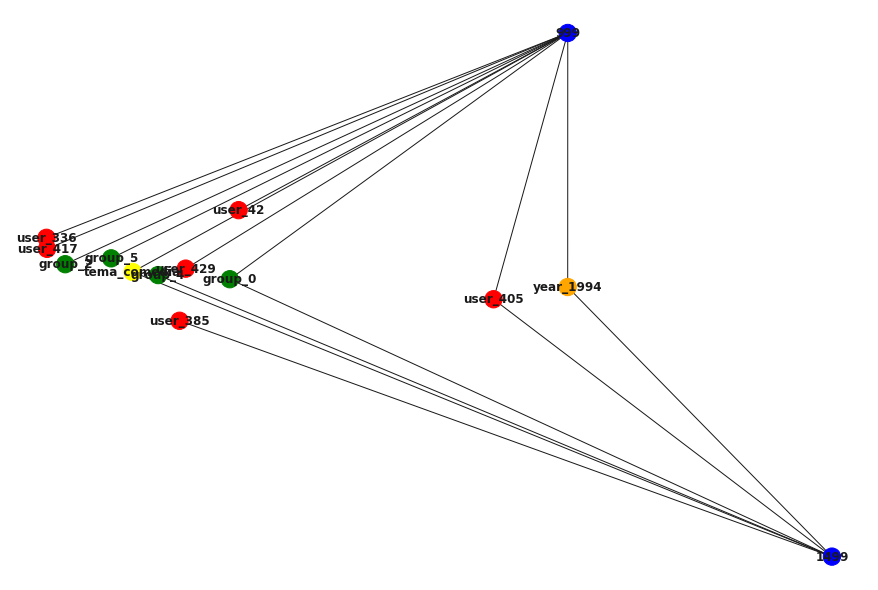

In [77]:
draw_sub_graph(G, get_all_adj_nodes(G, ["999","1499"]))

#### Adamic Adar Link Prediction

Com a função de recomendação definida na parte anterior, criaremos abaixo algumas funções que vão nos auxiliar a aplicar a metodologia para todos os filmes do dataframe. 

A função Adamic Adar Rec1 gerará para cada um dos ultimos 20 filme que um usuário assistiu, uma lista dos 10 filmes mais próximos a estes filmes. Isso indicaria o proximo filme que um usuário poderá assistir.

Nesta função, a lista de filmes recomendados é ordenada pela métrica Adamic Adar, da biblioteca NetworkX. Quanto mais alto o valor da métrica, mais proximos os filmes são uns dos outros.

Assim como nas funções de recomendação definidas anteriormente, as próximas também tiram da lista os filmes ja assistidos pelo usuario, indicando então apenas filmes inéditos.

In [78]:
def adamic_adar_rec1(G_, dataframe, dataframe_filmes, n=20, nome_coluna_id_usuario='id_usuario', nome_coluna_id_filme = 'id_filme'):
  """
  Função que gera recomendações ordenadas pela métrica Adamic Adar para todos os usuários do DataFrame passado como parâmetro
  
  Parâmetros
  ----------
  G_: Graph
      O grafo que armazena as relações existentes entre os dataframes de filmes e usuários
  dataframe: DataFrame
      O dataframe que contem o dados de interação entre usuários e filmes assistidos
  dataframe_filmes: DataFrame
      O dataframe que contem o dados dos filmes
  n: Integer
      Inteiro que armazena o número de filmes assistidos por ultimo pelo usuario que procuraremos pelos próximos 
  nome_coluna_id_usuaio: String
      String que armazena o nome da coluna que identifica os usuários nos dataframes
  nome_coluna_id_filme: String
      String que armazena o nome da coluna que identifica os filmes nos dataframes
  
  Retorno
  ----------
  DataFrame
      Um DataFrame com uma lista de 10 recomendações para cada usuário do DataFrame passado como parâmetro 
  """

  df_item_proximity = pd.DataFrame(columns=['id_filme_proximo', 'adamic_adar','id_filme'])
  df_retorno = pd.DataFrame(columns=['id_usuario','recomendacoes'])

  #Cria uma lista de filmes próximos
  for filme in dataframe_filmes[nome_coluna_id_filme]:
    if filme in dataframe[nome_coluna_id_filme].unique():
      df_aux = pd.DataFrame(get_recommendation_from_graph(G_, filme).head(10)).reset_index()
      df_aux['id_filme'] = filme
      df_aux.columns = ['id_filme_proximo', 'adamic_adar','id_filme']
      df_item_proximity = df_item_proximity.append(df_aux, ignore_index=True)

  # Para cada usuário, procura os 10 filmes mais próximos de cada um dos ultimos n filmes assistidos por ele
  # Tiramos da lista final os filmes ja assistidos pelo usuario, pois queremos indicar filmes unicos
  for usuario in dataframe[nome_coluna_id_usuario].unique():
    df_aux = dataframe[dataframe[nome_coluna_id_usuario]==usuario].sort_values(by=['data_avaliacao'],ascending=[False]).head(n)
    df_aux = df_aux.merge(df_item_proximity, how='left', left_on=nome_coluna_id_filme,right_on=nome_coluna_id_filme)
    df_aux = df_aux.sort_values(by='adamic_adar',ascending=False)
    df_aux = df_aux.drop_duplicates(subset=['id_filme_proximo'])
    df_aux = df_aux.merge(dataframe[dataframe[nome_coluna_id_usuario]==usuario][[nome_coluna_id_filme]], how='left', left_on='id_filme_proximo',right_on=nome_coluna_id_filme)
    df_aux = df_aux[df_aux[nome_coluna_id_filme + '_y'].isna()]

    # Se a lista de filmes retornados for menor que 10, tentamos forçar uma procura mais profunda de filmes inéditos.
    # Isso foi necessário para que a comparação entre Treino e Teste fosse mais efetiva.
    if len(list(df_aux.head(10).id_filme_proximo)) == 10:
      df_retorno = df_retorno.append(pd.DataFrame([[usuario,list(df_aux.head(10).id_filme_proximo)]],columns=['id_usuario','recomendacoes']), ignore_index=True)
    else:
      df_aux = dataframe[dataframe[nome_coluna_id_usuario]==usuario].sort_values(by=['data_avaliacao'],ascending=[False]).head(n+10)
      df_aux = df_aux.merge(df_item_proximity, how='left', left_on=nome_coluna_id_filme,right_on=nome_coluna_id_filme)
      df_aux = df_aux.sort_values(by='adamic_adar',ascending=False)
      df_aux = df_aux.drop_duplicates(subset=['id_filme_proximo'])
      df_aux = df_aux.merge(dataframe[dataframe[nome_coluna_id_usuario]==usuario][[nome_coluna_id_filme]], how='left', left_on='id_filme_proximo',right_on=nome_coluna_id_filme)
      df_aux = df_aux[df_aux[nome_coluna_id_filme + '_y'].isna()]
      df_retorno = df_retorno.append(pd.DataFrame([[usuario,list(df_aux.head(10).id_filme_proximo)]],columns=['id_usuario','recomendacoes']), ignore_index=True)

  return df_retorno


#### Analise do Adamic Adar Ordenada

A função adamic_adar_ordered é idêntica a anterior com exceção de aqui a lista de filmes que será recomendada para os usuários é ordenada pela métrica do SVD, definida anteriormente. 

A ideia para isso é a de que em Sistemas de Recomendações não é necessário apenas fazer uma boa recomendação de filmes, mas também acertar a ordem pela qual esses usuários vão preferir assistir a este filme.

A hipótese é a de que a métrica SVD pode melhorar a ordenação destes filmes recomendados. Veremos mais adiante neste notebook se esta hipótese é verdadeira ou não.


In [79]:
def adamic_adar_ordered(G_, dataframe, dataframe_filmes, dataframe_svd, n=20, nome_coluna_id_usuario='id_usuario', nome_coluna_id_filme = 'id_filme'):
  """
  Função que gera recomendações ordenadas pelo metodo SVD para todos os usuários do DataFrame passado como parâmetro
  
  Parâmetros
  ----------
  G_: Graph
      O grafo que armazena as relações existentes entre os dataframes de filmes e usuários
  dataframe: DataFrame
      O dataframe que contem o dados de interação entre usuários e filmes assistidos
  dataframe_filmes: DataFrame
      O dataframe que contem o dados dos filmes
  n: Integer
      Inteiro que armazena o número de filmes assistidos por ultimo pelo usuario que procuraremos pelos próximos 
  nome_coluna_id_usuaio: String
      String que armazena o nome da coluna que identifica os usuários nos dataframes
  nome_coluna_id_filme: String
      String que armazena o nome da coluna que identifica os filmes nos dataframes
  
  Retorno
  ----------
  DataFrame
      Um DataFrame com uma lista de 10 recomendações para cada usuário do DataFrame passado como parâmetro 
  """

  df_item_proximity = pd.DataFrame(columns=['id_filme_proximo', 'adamic_adar','id_filme'])
  df_retorno = pd.DataFrame(columns=['id_usuario','recomendacoes'])

  #Cria uma lista de filmes próximos
  for filme in dataframe_filmes[nome_coluna_id_filme]:
    if filme in dataframe[nome_coluna_id_filme].unique():
      df_aux = pd.DataFrame(get_recommendation_from_graph(G_, filme).head(10)).reset_index()
      df_aux['id_filme'] = filme
      df_aux.columns = ['id_filme_proximo', 'adamic_adar','id_filme']
      df_item_proximity = df_item_proximity.append(df_aux, ignore_index=True)

  # Para cada usuário, procura os 10 filmes mais próximos de cada um dos ultimos n filmes assistidos por ele
  # Tiramos da lista final os filmes ja assistidos pelo usuario, pois queremos indicar filmes unicos
  for usuario in dataframe[nome_coluna_id_usuario].unique():
    df_aux = dataframe[dataframe[nome_coluna_id_usuario]==usuario].sort_values(by=['data_avaliacao'],ascending=[False]).head(n)
    df_aux = df_aux.merge(df_item_proximity, how='left', left_on=nome_coluna_id_filme,right_on=nome_coluna_id_filme)
    ##### Parte nova que ordena pelo SVD
    films_list = list(df_aux[nome_coluna_id_filme])
    score_list = []

    for f in films_list:
      score_list.append(dataframe_svd.predict(str(usuario), str(f)).est)
    df_aux['score'] = score_list
    ##### Fim da parte nova
    df_aux = df_aux.sort_values(by='score',ascending=False)
    df_aux = df_aux.drop_duplicates(subset=['id_filme_proximo'])
    df_aux = df_aux.merge(dataframe[dataframe[nome_coluna_id_usuario]==usuario][[nome_coluna_id_filme]], how='left', left_on='id_filme_proximo',right_on=nome_coluna_id_filme)
    df_aux = df_aux[df_aux[nome_coluna_id_filme + '_y'].isna()]


    # Se a lista de filmes retornados for menor que 10, tentamos forçar uma procura mais profunda de filmes inéditos.
    # Isso foi necessário para que a comparação entre Treino e Teste fosse mais efetiva.
    if len(list(df_aux.head(10).id_filme_proximo)) == 10:
      df_retorno = df_retorno.append(pd.DataFrame([[usuario,list(df_aux.head(10).id_filme_proximo)]],columns=['id_usuario','recomendacoes']), ignore_index=True)
    else:
      df_aux = dataframe[dataframe[nome_coluna_id_usuario]==usuario].sort_values(by=['data_avaliacao'],ascending=[False]).head(n+10)
      df_aux = df_aux.merge(df_item_proximity, how='left', left_on=nome_coluna_id_filme,right_on=nome_coluna_id_filme)
      ##### Parte nova que ordena pelo SVD
      films_list = list(df_aux[nome_coluna_id_filme])
      score_list = []

      for f in films_list:
        score_list.append(dataframe_svd.predict(str(usuario), str(f)).est)
      df_aux['score'] = score_list
      ##### Fim da parte nova
      df_aux = df_aux.sort_values(by='score',ascending=False)
      df_aux = df_aux.drop_duplicates(subset=['id_filme_proximo'])
      df_aux = df_aux.merge(dataframe[dataframe[nome_coluna_id_usuario]==usuario][[nome_coluna_id_filme]], how='left', left_on='id_filme_proximo',right_on=nome_coluna_id_filme)
      df_aux = df_aux[df_aux[nome_coluna_id_filme + '_y'].isna()]

      df_retorno = df_retorno.append(pd.DataFrame([[usuario,list(df_aux.head(10).id_filme_proximo)]],columns=['id_usuario','recomendacoes']), ignore_index=True)

  return df_retorno

### Avaliação de Desempenho

Agora que as funções que serão utilizadas para aplicar as abordagens estão definidas, precisaremos definir métricas que nos ajudarão a julgar qual das abordagens apresentaram os melhores resultados.

Escolhemos 4 métricas principais para estas avaliações e as funções definidas abaixo representam cada uma delas.

#### Precisão e Precisão Ordenada

A primeira métrica que será discutida neste notebook é a Precisão. Muito comum para algorítmos de Classificação em Machine Learning, esta métrica avalia a quantidade de acertos dada a quantidade de predições realizadas pelo modelo.

Podemos definir um outro tipo de Precisão, mais adaptada ao contexto dos Sistemas de Recomendação que seria a Precisão Ordenada. A métrica padrão, como mencionada anteriormente, é boa para problemas de classificação. Entretanto, considerando que um usuário nesse contexto de recomendação de filmes tem uma quantidade finita de tempo e atenção, pode-se querer saber, então, não apenas os dez produtos que ele pode gostar, mas também quais são os mais prováveis dele assistir primeiro, transformando o problema de classificação num problema de ordenação. 

In [80]:
def apk(actual, predicted, k=10, func_type = 'ordered_precision'):
    """
    Calcula a precisão media até o k-esemio elemento.
    
    Parâmetros
    ----------
    actual : list
        Uma lista de itens realmente observados na amostra de teste

    predicted : list
        Uma lista de itens preditos por alguma funcao
    k : int
        O numero maximo de elementos que serao preditos/avaliados

    func_type: string
        O tipo da funcao que aplicaremos, seja a funcao que considera a ordem de
        acerto ou seja a função padrão de precisão

    Retorno
    -------
    score : double
            A precisão média da amostra até o k-esimo elemento
    """

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    if not actual or actual!=actual:
        return 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if (func_type == 'precision'):
      return num_hits / min(len(actual), k)
    elif (func_type == 'ordered_precision'):
      return score / min(len(actual), k)


A função apk acima calcula a precisão, enquanto que a função  mapk abaixo calcula a média dos resultados obtidos para cada um dos usuários da base. O parametro func_type ajuda a trocar entre as duas lógicas para a Precisão.

In [81]:
def mapk(actual, predicted, k=10, func_type = 'ordered_precision'):
    """
    Calcula a media da precisão media até o k-esemio elemento para todas as listas passadas como parâmetro.

    Parâmetros
    ----------
    actual : list
        Uma lista de itens realmente observados na amostra de teste

    predicted : list
        Uma lista de itens preditos por alguma funcao
    k : int
        O numero maximo de elementos que serao preditos/avaliados

    func_type: string
        O tipo da funcao que aplicaremos, seja a funcao que considera a ordem de
        acerto ou seja a função padrão de precisão

    Retorno
    -------
    score : double
            A media da precisão media até o k-esimo elemento para cada uma das listas passas como parâmetro
    """
    return np.mean([apk(a,p,k, func_type) for a,p in zip(actual, predicted)])

#### Cobertura

Enquanto as duas primeiras estavam preocupadas com a relevância de uma recomendação ao usuário, as próximas funções trazem uma visão de quão surpreendentes (positivamente) podem ser as recomendações aos usuários. Uma métrica bastante interessante para algorítmos de recomendação é a Cobertura, isto é, o quão abrangente ou o quanto de alcance tem uma certa função de recomendação dado um conjunto de possíveis filmes a serem recomendados.

A Cobertura, ou Coverage, esta definida abaixo com a função prediction_coverage.

In [82]:
def prediction_coverage(predicted, catalog):
    """
    Calcula a cobertura da predição para uma lista de recomendações.

    Parâmetros
    ----------
    predicted : a list of lists
        Predições ordenadas
        exemplo: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]

    catalog: list
        Uma lista de todos os itens unicos possiveis de serem recomendados
        exemplo: ['A', 'B', 'C', 'X', 'Y', Z]

    Retorno
    ----------
    prediction_coverage: A cobertura da predição como um percentual aproximada
    de duas casas decimais
    
    """
    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_predictions = len(set(predicted_flattened))
    prediction_coverage = round(unique_predictions/(len(catalog)* 1.0)*100,4)
    return prediction_coverage

#### Personalização

Por fim, a métrica Personalização destaca quão diferente são as listas de filmes recomendados aos usuários do conjunto de dados. A função personalization abaixo ajuda a definir este conceito.

In [83]:
def personalization(predicted):
    """
    Calcula a medida Personalização, ou seja, a similaridade entre as recomendações realizadas aos usuários.
    O grau alto indica uma boa personalização (as listas de filmes são diferentes).
    O grau baixo indica uma ma personalização (as listas de filmes são parecidas).

    Parâmetros:
    ----------
    predicted : a list of lists
        Predições ordenadas
        exemplo: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]

    Retorno:
    -------
        O grau de personalização dada o conjunto de recomendações 
    """

    def make_rec_matrix(predicted):
        df_aux = pd.DataFrame(data=predicted).reset_index().melt(
            id_vars='index', value_name='item',
        )
        df_aux = df_aux[['index', 'item']].pivot(index='index', columns='item', values='item')
        df_aux = pd.notna(df_aux)*1
        rec_matrix = sp.csr_matrix(df_aux.values)
        return rec_matrix

    #Cria a matriz de recomendações 
    predicted = np.array(predicted)
    rec_matrix_sparse = make_rec_matrix(predicted)

    #Calcula a similaridade para cada recomendação a usuario na lista
    similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)

    #Calcula a similaridade media
    dim = similarity.shape[0]
    personalization = (similarity.sum() - dim) / (dim * (dim - 1))
    return round(1-personalization,4)

### Resultados obtidos

A partir de todas as funções definidas, partimos para a seção de aplicação e colheita dos resultados. Antes, primeiro, redefinimos o formato do dataframe df_test para podermos avaliar de uma maneira mais objetiva os resultados obtidos.

In [84]:
df_aux = pd.DataFrame(columns=['id_usuario','actual'])
for usuario in df_test.id_usuario.unique():
  df_aux = df_aux.append(pd.DataFrame([[usuario,list(df_test[df_test['id_usuario']==usuario].id_filme)]],columns=['id_usuario','actual']), ignore_index=True)
df_test = df_aux.copy()

df_test.head()

,id_usuario,actual
0,1,"[152, 197, 184, 69, 249, 224, 51, 233, 64, 153..."
1,10,"[269, 617, 663, 602, 285, 137, 497, 686, 132, ..."
2,100,"[344, 323, 266, 690, 326, 292, 990, 313, 289, ..."
3,101,"[237, 742, 819, 222, 1009, 257, 763, 284, 1057..."
4,102,"[327, 241, 993, 195, 431, 385, 384, 67, 515, 7..."


#### Analise do Adamic Adar

A função abaixo realiza a aplicação da abordagem por Redes Complexas e ordenação pela métrica Admic Adar.

In [85]:
df_result_adamic_adar_rec = adamic_adar_rec1(G, df_train, df_item, 20)

O DataFrame resultante tem o mesmo formato do DataFrame df_test, basicamente temos uma linha para cada usuário e três colunas finais. Sendo elas, o id_usuario, que identifica cada usuario da base de dados, uma coluna cotendo uma array de 10 elementos obtidos do conjunto de teste e que representam os filmes que o usuario poderia assistir no futuro e, tambem, uma ultima coluna contendo um array de 10 elementos obtidos como retorno da função acima.

In [86]:
df_result_adamic_adar_rec = df_result_adamic_adar_rec.merge(df_test, how='left', left_on='id_usuario', right_on='id_usuario')

A função abaixo aplica métrica de avaliação de Precisão Ordenada Média.

In [87]:
mapk(df_result_adamic_adar_rec.actual, df_result_adamic_adar_rec.recomendacoes)

0.23633018950885987

A função abaixo aplica métrica de avaliação de Precisão Média.

In [88]:
mapk(df_result_adamic_adar_rec.actual, df_result_adamic_adar_rec.recomendacoes, func_type = 'precision')

0.34833795013850416

A função abaixo aplica métrica de avaliação de Personalização.

In [89]:
personalization(df_result_adamic_adar_rec.recomendacoes.to_list())

0.6549

A função abaixo aplica métrica de avaliação de Cobertura.

In [90]:
prediction_coverage(df_result_adamic_adar_rec.recomendacoes.to_list(),df_train.id_filme.unique())

7.226

#### Analise do Adamic Adar Ordenada

A função abaixo realiza a aplicação da abordagem por Redes Complexas e ordenação pela métrica SVD.

In [91]:
df_result_adamic_adar_ordered = adamic_adar_ordered(G, df_train, df_item, svd, 20)

Assim como na abordagem anterior, criamos o DataFrame que coloca lado a lado os arrays de predição e de do conjunto de testes.

In [92]:
df_result_adamic_adar_ordered = df_result_adamic_adar_ordered.merge(df_test, how='left', left_on='id_usuario', right_on='id_usuario')

A função abaixo aplica métrica de avaliação de Precisão Ordenada Média.

In [93]:
mapk(df_result_adamic_adar_ordered.actual, df_result_adamic_adar_ordered.recomendacoes)

0.2310690652068768

Em comparação com a primeira abordagem, não tivemos ganhos significativos entre a utilização da ordenação por SVD vs a ordenação por Admic Adar no criterio da Precisão Ordenada Média. Ambos preservam acertos de aproximadamente 0.23.

A função abaixo aplica métrica de avaliação de Precisão Média.

In [94]:
mapk(df_result_adamic_adar_ordered.actual, df_result_adamic_adar_ordered.recomendacoes, func_type = 'precision')

0.354016620498615

O mesmo vale para a Precisão Média, obtivemos resultados muito parecidos.

A função abaixo aplica métrica de avaliação de Personalização.

In [95]:
personalization(df_result_adamic_adar_ordered.recomendacoes.to_list())

0.7288

Ja para a Personalização, e ordenação por SVD apresentou resultados melhores que a ordenação por Adamic Adar. Tivemos aqui aproximadamente 0.73 vs aproximadamente 0.65 da abordagem anterior.

A função abaixo aplica métrica de avaliação de Cobertura.

In [96]:
prediction_coverage(df_result_adamic_adar_ordered.recomendacoes.to_list(),df_train.id_filme.unique())

12.3086

Em Cobertura tivemos resultados superiores com esta ultima abordagem. Temos que com SVD uma cobertura de aproximadamente 12% da base de dados, enquanto na abordagem anterior tínhamos aproximadamente 7%.

#### Analise do SVD

A função abaixo realiza a aplicação da abordagem por SVD.

In [97]:
df_retorno_svd = pd.DataFrame(columns=['id_usuario','avaliacao'])
for usuario in df_train.id_usuario.unique():
  df_aux = get_recommendations_collaborative_filtering(usuario,svd,df_item, df_train, 10)
  df_retorno_svd = df_retorno_svd.append(pd.DataFrame([[usuario,list(df_aux.head(10).id_filme)]],columns=['id_usuario','avaliacao']), ignore_index=True)

Assim como na abordagem anterior, criamos o DataFrame que coloca lado a lado os arrays de predição e de do conjunto de testes.

In [98]:
df_retorno_svd = df_retorno_svd.merge(df_test, how='left', left_on='id_usuario', right_on='id_usuario')

A função abaixo aplica métrica de avaliação de Precisão Ordenada Média.

In [99]:
mapk(df_retorno_svd.actual, df_retorno_svd.avaliacao)

0.07620196324143692

Em comparação com as duas abordagens anteriores a Precisão Ordenada Media para o SVD é bem pior. Aqui temos aproximadamente 0.07 enquanto que antes tinhamos em ambas algo em torno de 0.23.

A função abaixo aplica métrica de avaliação de Precisão Média.

In [100]:
mapk(df_retorno_svd.actual, df_retorno_svd.avaliacao, func_type = 'precision')

0.14501385041551246

A Precisão Média agora também fica bem atrás, aproximadamente 0.14 contra aproximadamente 0.35 na melhor abordagem até aqui.

A função abaixo aplica métrica de avaliação de Personalização.

In [101]:
personalization(df_retorno_svd.avaliacao.to_list())

0.7269

A Personalização desta abordagem é melhor do que a da Redes Complexas com Adamic Adar e empata com a da Redes Complexas com SVD. Lado positivo é que esta abordagem é tecnicamente bem mais simples que as outras, mas teve esses números positivos.

A função abaixo aplica métrica de avaliação de Cobertura.

In [102]:
prediction_coverage(df_retorno_svd.avaliacao.to_list(),df_train.id_filme.unique())

12.9822

A Cobertura desta abordagem foi a melhor até aqui, com aproximadamente 13% dos filmes recomendados versus os 12% da melhor abordagem anterior. Curioso que as duas melhores abordagem levam em consideração a ordenação por SVD, que aparentemente se mostra melhor do que Adamic Adar.

#### Analise do Popularidade com Cluster

A função abaixo realiza a aplicação da abordagem por Popularidade com Cluster.

In [103]:
df_retorno_cluster = pd.DataFrame(columns=['id_usuario','avaliacao'])
for usuario in df_train.id_usuario.unique():
  df_aux = current_wr_imdb(get_recommendations_clusterized(usuario, df_usuarios, df_train), periodo_maximo_considerado=10000).sort_values(by='popularidade', ascending=False)
  df_retorno_cluster = df_retorno_cluster.append(pd.DataFrame([[usuario,list(df_aux.head(10).id_filme)]],columns=['id_usuario','avaliacao']), ignore_index=True)
df_retorno_cluster.head()

,id_usuario,avaliacao
0,1,"[64, 98, 127, 318, 483, 357, 475, 603, 427, 23]"
1,10,"[313, 190, 316, 515, 603, 427, 318, 96, 528, 272]"
2,100,"[318, 357, 22, 1, 275, 12, 603, 100, 127, 511]"
3,101,"[50, 172, 181, 313, 64, 127, 12, 302, 174, 79]"
4,102,"[483, 357, 318, 427, 174, 515, 480, 22, 28, 479]"


Assim como na abordagem anterior, criamos o DataFrame que coloca lado a lado os arrays de predição e de do conjunto de testes.

In [104]:
df_retorno_cluster = df_retorno_cluster.merge(df_test, how='left', left_on='id_usuario', right_on='id_usuario')

A função abaixo aplica métrica de avaliação de Precisão Ordenada Média.

In [105]:
mapk(df_retorno_cluster.actual, df_retorno_cluster.avaliacao)

0.1432950798047751

A Precisão Média nesta abordagem é de aproximadamente 0.14, o que é o dobro da apresentada da abordagem anterior, mas ainda fica atrás das duas primeiras abordagens por Redes Complexas que tinham aproximadamente 0.23.

A função abaixo aplica métrica de avaliação de Precisão Média.

In [106]:
mapk(df_retorno_cluster.actual, df_retorno_cluster.avaliacao, func_type = 'precision')

0.22714681440443213

A Precisão Média também é superior a abordagem anterior, que tinha 0.14 aproximadamente, e também fica atrás das duas primeiras abordagens por Redes Complexas que tinham aproximadamente 0.35.

A função abaixo aplica métrica de avaliação de Personalização.

In [107]:
personalization(df_retorno_cluster.avaliacao.to_list())

0.7247

A Personalização também apresenta números muito bons se comparados as outras abordagens. Ela se aproxima muito das duas ultimas e fica melhor do que a primeira.

A função abaixo aplica métrica de avaliação de Cobertura.

In [108]:
prediction_coverage(df_retorno_cluster.avaliacao.to_list(),df_train.id_filme.unique())

7.5934

A Cobertura, por sua vez, junto com o resultado obtido com Redes Complexas Adamic Adar são os piores ja vistos até aqui.

#### Analise do Popularidade sem Cluster

A função abaixo realiza a aplicação da abordagem por Popularidade sem Cluster.

In [109]:
df_retorno_sem_cluster = pd.DataFrame(columns=['id_usuario','avaliacao'])
for usuario in df_train.id_usuario.unique():
  df_aux = current_wr_imdb(df_train, periodo_maximo_considerado=10000).sort_values(by='popularidade', ascending=False)
  dataframe_auxiliar_ = df_train[['id_usuario','id_filme']].copy()
  dataframe_auxiliar_.columns = ['iid_usuario','iid_filme']
  dataframe_auxiliar_ = dataframe_auxiliar_[dataframe_auxiliar_['iid_usuario']==str(usuario)]
  df_aux = df_aux.merge(dataframe_auxiliar_, how='left', left_on='id_filme', right_on='iid_filme')
  df_aux = df_aux[df_aux['iid_filme'].isna()]
  df_aux.drop(columns=['iid_filme','iid_usuario'], inplace=True)
  df_retorno_sem_cluster = df_retorno_sem_cluster.append(pd.DataFrame([[usuario,list(df_aux.head(10).id_filme)]],columns=['id_usuario','avaliacao']), ignore_index=True)

Assim como na abordagem anterior, criamos o DataFrame que coloca lado a lado os arrays de predição e de do conjunto de testes.

In [110]:
df_retorno_sem_cluster = df_retorno_sem_cluster.merge(df_test, how='left', left_on='id_usuario', right_on='id_usuario')

A função abaixo aplica métrica de avaliação de Precisão Ordenada Média.

In [111]:
mapk(df_retorno_sem_cluster.actual, df_retorno_sem_cluster.avaliacao)

0.14431616321505517

A Precisão Média nesta abordagem é de aproximadamente 0.14, a mesma apresentada na abordagem anterior, o que é o dobro da apresentada da abordagem com SVD, mas ainda fica atrás das duas primeiras abordagens por Redes Complexas que tinham aproximadamente 0.23.

A função abaixo aplica métrica de avaliação de Precisão Média.

In [112]:
mapk(df_retorno_sem_cluster.actual, df_retorno_sem_cluster.avaliacao, func_type = 'precision')

0.23282548476454293

A Precisão Média também é a terceira melhor já apresentada até aqui, com aproximadamente 0.23. Ainda fica atrás das duas primeiras abordagens por Redes Complexas que tinham aproximadamente 0.35.

A função abaixo aplica métrica de avaliação de Personalização.

In [113]:
personalization(df_retorno_sem_cluster.avaliacao.to_list())

0.4156

A Personalização para esta abordagem apresentou o pior resultado até então, com aproximadamente 0.41. A pior abordagem anteriormente (Redes Complexas Adamic Adar) tinha 50% mais Personalização do que está.

A função abaixo aplica métrica de avaliação de Cobertura.

In [114]:
prediction_coverage(df_retorno_sem_cluster.avaliacao.to_list(),df_train.id_filme.unique())

2.327

A Cobertura também bateu recorde negativo! Foi a pior abordagem até aqui, com aproximadamente 2%.

#### Analise do Randômico

A função abaixo realiza a aplicação da abordagem Randômica, isto é, um sistema que recomenda filmes de modo aleatório para cada usuário. Implementamos este modelo para que fossemos capaz de avaliar de forma comparável os resultados das abordagens sugeridas. Se uma abordagem não atinge resultados melhores que uma escolha ao acaso do usuário, ela não é uma boa abordagem.

In [115]:
df_retorno_random = pd.DataFrame(columns=['id_usuario','avaliacao'])
for usuario in df_train.id_usuario.unique():
  df_aux = df_train[df_train['id_usuario']!=str(usuario)].copy()
  df_aux = df_aux.sample(100, random_state=1)
  df_aux = df_aux.drop_duplicates(subset=['id_filme'])
  df_retorno_random = df_retorno_random.append(pd.DataFrame([[usuario,list(df_aux.head(10).id_filme)]],columns=['id_usuario','avaliacao']), ignore_index=True)

Assim como na abordagem anterior, criamos o DataFrame que coloca lado a lado os arrays de predição e de do conjunto de testes.

In [116]:
df_retorno_random = df_retorno_random.merge(df_test, how='left', left_on='id_usuario', right_on='id_usuario')

A função abaixo aplica métrica de avaliação de Precisão Ordenada Média.

In [117]:
mapk(df_retorno_random.actual, df_retorno_random.avaliacao)

0.02489145011651937

A Precisão Ordenda para esta abordagem ficou em aproximadamente 0.0248. A pior abordagem neste critério foi a SVD com aproximadamente 0.0720 e a melhor foi a Redes Complexas Adamic Adar com 0.2363.

A função abaixo aplica métrica de avaliação de Precisão Média.

In [118]:
mapk(df_retorno_random.actual, df_retorno_random.avaliacao, func_type = 'precision')

0.06301939058171745

A Precisão para esta abordagem ficou em aproximadamente 0.0630. A pior abordagem neste critério foi a SVD com aproximadamente 0.1448 e a melhor foi a Redes Complexas Adamic Adar Ordenada com 0.3559.

A função abaixo aplica métrica de avaliação de Personalização.

In [119]:
personalization(df_retorno_random.avaliacao.to_list())

0.9709

A Personalização para esta abordagem ficou em aproximadamente 0.9709, o que é um resultado excepcional, entretando isso era esperado pois como estamos falando de um algoritmo aleatório, temos a tendencia de ter recomendações completamente diferentes umas das outras. A pior abordagem neste critério foi a Popularidade sem Cluster com aproximadamente 0.4156 e a melhor (até então) foi a Redes Complexas Adamic Adar Ordenada com 0.7324.

A função abaixo aplica métrica de avaliação de Cobertura.

In [120]:
prediction_coverage(df_retorno_random.avaliacao.to_list(),df_train.id_filme.unique())

49.1121

A Cobertura para esta abordagem ficou em aproximadamente 49.1121, o que também é um resultado excepcional, a mesma explicação dada para a Personalização pode ser encaixada aqui, como a abordagem é aleatória é esperado que ela percorra por mais filmes diferentes dentro da amostra. A pior abordagem neste critério foi a Popularidade sem Cluster com aproximadamente 2.3270 e a melhor (até então) foi a SVD com 13.9008.

## 5. Conclusão

O equilíbrio entre as métricas de avaliação apresentadas nos levou a entender que a abordagem híbrida de Adamic Adar Link Prediction com ordenação dada por Single Value Decomposition obteve o melhor desempenho geral entre todas as abordagens estudadas.

Pela simplicidade de cálculo e pelos resultados razoáveis obtidos em cada métrica de avaliação, entende-se também que a abordagem baseada em Agrupamento Hierárquico com Popularidade seria uma boa alternativa aos casos em que não há o histórico de interações do usuário.

Finalmente, entende-se que seria interessante explorar em trabalhos futuros os valores ideais dos parâmetros definidos em cada abordagem deste trabalho e também os impactos nas métricas de avaliação com uma utilização conjunta dessas duas abordagens.